In [1]:
import os
import pathlib
import re
import copy
import warnings
import time
import json
import pickle

from sklearn import svm
from sys import getsizeof

import cv2
import xmltodict
import numpy as np
import pandas as pd
import tiffcapture as tc

from tifffile import imsave
from matplotlib import pyplot as pt

%matplotlib inline

In [ ]:
from notebook.nbextensions import check_nbextension
check_nbextension('codefolding', user=True)
check_nbextension('codefolding/main.js', user=True)

ext_require_path = 'codefolding/main'
try:  # notebook >= 4.2.0
    from notebook.nbextensions import enable_nbextension
    enable_nbextension('notebook', ext_require_path)
except ImportError:
    from notebook.nbextensions import EnableNBExtensionApp
    EnableNBExtensionApp().enable_nbextension(ext_require_path)

In [2]:
TIME_UNIT_FACTOR = 600
PIXEL_INCH_RATIO = .647
DIAMETER = 15

In [3]:
# path to exit data
exit_dat = '../results/40-47.csv'

# Function Defs

In [4]:
def removekey(d, key):
    """
    Remove a key from a  dictionary without destroying the reference
    to removed object (which might be used by other processes)
    """
    if key in d:
        r = dict(d)
        del r[key]
        return r

In [5]:
def parse_trees(links_tab, verbose=False, parse_velocity_displacement=False):
    """
    Given 'links in tab statistics' from TrackMate.
    Construct data structures representing trees ('tree') and
    their branching ('branch') respectively.
    
    -   'tree' contains mapping of TREE_ID (which is the same as
        the id of root's SPOT_ID) to its associated tree.
        Each tree is in turn a map of TREE_BRANCH_ID
        (which is the branch's first spot's SPOT_ID)
        to its branch which is represented as list of SPOT_ID's.
    -   'branch' encodes how the tree is structured. It contains
        mapping of TREE_ID to the branching configuration.
        The branching configuration is encoded as mapping of
        BRANCH_ID to its two children's BRANCH_ID.
    """
    
    links_tab = links_tab.copy()
    links_tab.index = links_tab.SPOT_TARGET_ID

    tree = {}
    branch = {}
    if parse_velocity_displacement:
        velocity = {}
        displacement = {}
        
    for track in links_tab.TRACK_ID.unique():
    
        sub = links_tab[links_tab.TRACK_ID == track]

        this_lines = {}
        this_branches = {}
        if parse_velocity_displacement:
            this_velocities = {}
            this_displacements = {}
        stack = []
    
        groot = sub.iloc[0][3]
        if verbose:
            print("Parsing tree %s" % groot)
        stack.append(groot)
    
        while len(stack) > 0:
        
            root = stack.pop()
            track = [root]
            if parse_velocity_displacement:
                # initial velocity and displacement is always 0
                vel = [0]
                disp = [0]
            
            if verbose:
                print("Parsing subtree %s" % root)
            nsub = sub[sub.SPOT_SOURCE_ID == root]
        
            while nsub.index.size > 0:
                if nsub.index.size == 1:
                    this = nsub.iloc[0][4]
                    track.append(this)
                    if parse_velocity_displacement:
                        vel.append(sub.loc[this]['VELOCITY'])
                        disp.append(sub.loc[this]['DISPLACEMENT'])
                    nsub = sub[sub.SPOT_SOURCE_ID == this]
                else:
                    stack.append(nsub.iloc[0][4])
                    stack.append(nsub.iloc[1][4])
                    this_branches[root] = (nsub.iloc[0][4], nsub.iloc[1][4])
                    if verbose:
                        print("breaking")
                    break
                
            this_lines[root] = track
            if parse_velocity_displacement:
                this_velocities[root] = vel
                this_displacements[root] = disp
            if verbose:
                print("adding branch %s" % root)
    
        if verbose:
            print("Finishing...")
        tree[groot] = this_lines
        branch[groot] = this_branches
        if parse_velocity_displacement:
            velocity[groot] = this_velocities
            displacement[groot] = this_displacements
        
    if parse_velocity_displacement:
        return tree, branch, velocity, displacement
    else:
        return tree, branch

In [6]:
def extract_values(tree, spots_tab, colnames, verbose=False):
    """
    Extract varoius measurement values from spots statistics and save it
    in format similar to parsed tree. The list of values to be extracted
    from spots statistics is defined in 'colnames' 
    
    The information will be stored in following format:
    map(TYPE:(TREE_ID:TREE_BRANCH:list(VALUES))
    
    """
    
    vals = {}

    for tr in tree:
    
        if verbose:
            print("extracting values for %s" % tr)
    
        for colname in colnames:
        
            val_tree = {}
        
            for br in tree[tr]:
            
                brkeys = tree[tr][br]
                brvals = [sits[sits.ID == x][colname].values[0] for x in brkeys]
            
                val_tree[br] = brvals
            
            if colname not in vals:
                vals[colname] = {}
            
            vals[colname][tr] = val_tree
            
    return vals

In [7]:
def filter_trees_by_time(tree, branch, tree_values, min_time=0, max_time=10):
    """
    Filter out trees which measurement time start before or after
    the time as defined in 'min_time' and 'max_time'.
    
    Measurement time is defined as the return value from TrackMate
    encoded as 'POSITION_T'
    """
    
    tree_values_filtered = {}
    tree = copy.deepcopy(tree)
    branch = copy.deepcopy(branch)

    for v in tree_values.keys():
        tree_values_filtered[v] = {}

    for key in tree_values['POSITION_T'].keys():
    
        if (tree_values['POSITION_T'][key][key][0] >= min_time) and (tree_values['POSITION_T'][key][key][0] <= max_time):
            for k in tree_values_filtered.keys():
                tree_values_filtered[k][key] = tree_values[k][key]
        else:
            tree = removekey(tree, key)
            branch = removekey(branch, key)
                
    return  tree, branch, tree_values_filtered 

In [8]:
def get_video(path, to_rgb=False):
    """
    Read TIFF file containing multiple stacks (a video)
    and return sequential array of frame encoded as
    multidimensional array
    """
    
    tif = tc.opentiff(path)
    
    ## first image
    _, first_img = tif.retrieve()
    if to_rgb:
        first_img = cv2.cvtColor(first_img,cv2.COLOR_GRAY2RGB)

    ## slices
    pics = [first_img]

    for slide in tif:
        # convert grayscale to RGB
        if to_rgb:
            slide = cv2.cvtColor(slide, cv2.COLOR_GRAY2RGB)
        pics.append(slide)
    
    return pics

In [9]:
## OLD IMPLEM: TODO REMOVE

def extract_brightness(tree_id, tree, tree_values, reference_vid_path, diameter=DIAMETER, caspase=True, normalize=True):
    """
    Given cell death signal video, extract brightness level for each position
    of tracked cell trees, if such poisition coincides with the.
    
    This function returns:
    -   the brightness level of each spot in the tree, if such is measured.
        The encoding follows that of the tree itself
    -   cell death signal time-lapsed video of containing the cell belonging
        to the 'tree_id'. Useful for debugging/sanity testing 
    """
    
    pics = get_video(reference_vid_path)
    pics_intersect = []

    t_time = tree_values['POSITION_T'][tree_id] # tree_values
    t_x = tree_values['POSITION_X'][tree_id]
    t_y = tree_values['POSITION_Y'][tree_id]
    t_tree = tree[tree_id]

    t_brightness = {}
    
    if normalize:
        base_brightness = []
        for pic in pics:
            base_brightness.append(cv2.sumElems(pic)[0] / float(pic.shape[0] * pic.shape[1]))

    for br in t_tree:
        brch = t_tree[br]
        x = t_x[br]
        y = t_y[br]
        time = t_time[br]
        brightness = []
    
        for i in range(len(brch)):
            if caspase:
                if ((time[i] - 77400) >= 0) & ((time[i] - 77400) % 1800 == 0):
                    pos = (time[i] - 77400) // 1800
                    pic_base = pics[pos]
                    pic_bg = np.zeros(pic_base.shape, np.uint16)
                    pic_bg = cv2.circle(pic_bg, 
                                       (int(x[i] / PIXEL_INCH_RATIO), int(y[i] / PIXEL_INCH_RATIO)),
                                       int(diameter / PIXEL_INCH_RATIO),
                                       (255, 255, 255),
                                       -1)
                    pic = cv2.bitwise_and(pic_base, pic_bg)
                    if normalize:
                        brightness.append(cv2.sumElems(pic)[0] / (base_brightness[pos] + .0001))
                    else:
                        brightness.append(cv2.sumElems(pic)[0])
                    pics_intersect.append(pic)
                else:
                    brightness.append(np.nan)
            else:
                if time[i] % 1800 == 0:
                    pos = time[i] // 1800
                    pic_base = pics[pos]
                    pic_bg = np.zeros(pic_base.shape, np.uint16)
                    pic_bg = cv2.circle(pic_bg, 
                                       (int(x[i] / PIXEL_INCH_RATIO), int(y[i] / PIXEL_INCH_RATIO)),
                                       int(diameter / PIXEL_INCH_RATIO),
                                       (255, 255, 255),
                                       -1)
                    pic = cv2.bitwise_and(pic_base, pic_bg)
                    if normalize:
                        brightness.append(cv2.sumElems(pic)[0] / (base_brightness[pos] + .0001))
                    else:
                        brightness.append(cv2.sumElems(pic)[0])
                    pics_intersect.append(pic)
                else:
                    brightness.append(np.nan)
            
        t_brightness[br] = brightness
    return t_brightness, np.array(pics_intersect)


def extract_brightness(tree_id, tree, tree_values, reference_vid_path, diameter=DIAMETER, caspase=True, normalize=True):
    """
    Given cell death signal video, extract brightness level for each position
    of tracked cell trees, if such poisition coincides with the.
    
    This function returns:
    -   the brightness level of each spot in the tree, if such is measured.
        The encoding follows that of the tree itself
    -   cell death signal time-lapsed video of containing the cell belonging
        to the 'tree_id'. Useful for debugging/sanity testing 
    """
    
    pics = get_video(reference_vid_path)
#     pics = [pc.astype(np.int64) for pc in pics]
    pics_intersect = []

    t_time = tree_values['POSITION_T'][tree_id] # tree_values
    t_x = tree_values['POSITION_X'][tree_id]
    t_y = tree_values['POSITION_Y'][tree_id]
    t_tree = tree[tree_id]

    t_brightness = {}
    
    if normalize:
        base_brightness = [np.sum(pc.astype(np.int64)) / float(pc.shape[0] * pc.shape[1]) for pc in pics]
#         base_brightness = [np.sum(pc) / float(pc.shape[0] * pc.shape[1]) for pc in pics]
#         base_brightness = []
#         for pic in pics:
#             base_brightness.append(cv2.sumElems(pic)[0] / float(pic.shape[0] * pic.shape[1]))

    for br in t_tree:
        brch = t_tree[br]
        x = t_x[br]
        y = t_y[br]
        time = t_time[br]
        brightness = []
    
        for i in range(len(brch)):
            if caspase:
                if ((time[i] - 77400) >= 0) & ((time[i] - 77400) % 1800 == 0):
                    pos = (time[i] - 77400) // 1800
                    pic_base = pics[pos]
#                     pic_bg = np.zeros(pic_base.shape, np.int64)
                    pic_bg = np.zeros(pic_base.shape, np.uint16)
                    pic_bg = cv2.circle(pic_bg, 
                                       (int(x[i] / PIXEL_INCH_RATIO), int(y[i] / PIXEL_INCH_RATIO)),
                                       int(diameter / PIXEL_INCH_RATIO),
                                       (255, 255, 255),
                                       -1)
#                     print(pic_base.dtype)
#                     print(pic_bg.dtype)
#                     print("#" * 10)
                    pic = cv2.bitwise_and(pic_base, pic_bg)
                    if normalize:
                        brightness.append(np.sum(pic, dtype=np.int64) / (base_brightness[pos] + .0001))
#                         brightness.append(np.sum(pic) / (base_brightness[pos] + .0001))
#                         brightness.append(cv2.sumElems(pic)[0] / (base_brightness[pos] + .0001))
                    else:
                        brightness.append(np.sum(pic, dtype=np.int64))
#                         brightness.append(np.sum(pic))
#                         brightness.append(cv2.sumElems(pic)[0])
                    pics_intersect.append(pic)
                else:
                    brightness.append(np.nan)
            else:
                if time[i] % 1800 == 0:
                    pos = time[i] // 1800
                    pic_base = pics[pos]
#                     pic_bg = np.zeros(pic_base.shape, np.int64)
                    pic_bg = np.zeros(pic_base.shape, np.uint16)
                    pic_bg = cv2.circle(pic_bg, 
                                       (int(x[i] / PIXEL_INCH_RATIO), int(y[i] / PIXEL_INCH_RATIO)),
                                       int(diameter / PIXEL_INCH_RATIO),
                                       (255, 255, 255),
                                       -1)
#                     print(pic_base.dtype)
#                     print(pic_bg.dtype)
#                     print("#" * 10)
                    pic = cv2.bitwise_and(pic_base, pic_bg)
                    if normalize:
                        brightness.append(np.sum(pic, dtype=np.int64) / (base_brightness[pos] + .0001))
#                         brightness.append(np.sum(pic) / (base_brightness[pos] + .0001))
#                         brightness.append(cv2.sumElems(pic)[0] / (base_brightness[pos] + .0001))
                    else:
                        brightness.append(np.sum(pic, dtype=np.int64))
#                         brightness.append(np.sum(pic))
#                         brightness.append(cv2.sumElems(pic)[0])
                    pics_intersect.append(pic)
                else:
                    brightness.append(np.nan)
            
        t_brightness[br] = brightness
    return t_brightness, np.array(pics_intersect)

In [10]:
def extract_brightness_template(tree_id, tree, tree_values, pics, diameter=DIAMETER, caspase=True, normalize=True):
    """
    Similar to extract_brightness(), except that it
    takes video template form the user
    
    This function returns:
    -   the brightness level of each spot in the tree, if such is measured.
        The encoding follows that of the tree itself
    -   cell death signal time-lapsed video of containing the cell belonging
        to the 'tree_id'. Useful for debugging/sanity testing 
    """
    
    pics_intersect = []

    t_time = tree_values['POSITION_T'][tree_id] # tree_values
    t_x = tree_values['POSITION_X'][tree_id]
    t_y = tree_values['POSITION_Y'][tree_id]
    t_tree = tree[tree_id]

    t_brightness = {}
    
    if normalize:
        base_brightness = []
        for pic in pics:
            base_brightness.append(cv2.sumElems(pic)[0] / float(pic.shape[0] * pic.shape[1]))

    for br in t_tree:
        brch = t_tree[br]
        x = t_x[br]
        y = t_y[br]
        time = t_time[br]
        brightness = []
    
        for i in range(len(brch)):
            if caspase:
                if ((time[i] - 77400) >= 0) & ((time[i] - 77400) % 1800 == 0):
                    pos = (time[i] - 77400) // 1800
                    pic_base = pics[pos]
                    pic_bg = np.zeros(pic_base.shape, np.uint16)
                    pic_bg = cv2.circle(pic_bg, 
                                       (int(x[i] / PIXEL_INCH_RATIO), int(y[i] / PIXEL_INCH_RATIO)),
                                       int(diameter / PIXEL_INCH_RATIO),
                                       (255, 255, 255),
                                       -1)
                    pic = cv2.bitwise_and(pic_base, pic_bg)
                    if normalize:
                        brightness.append(cv2.sumElems(pic)[0] / (base_brightness[pos] + .0001))
                    else:
                        brightness.append(cv2.sumElems(pic)[0])
                    pics_intersect.append(pic)
                else:
                    brightness.append(np.nan)
            else:
                if time[i] % 1800 == 0:
                    pos = time[i] // 1800
                    pic_base = pics[pos]
                    pic_bg = np.zeros(pic_base.shape, np.uint16)
                    pic_bg = cv2.circle(pic_bg, 
                                       (int(x[i] / PIXEL_INCH_RATIO), int(y[i] / PIXEL_INCH_RATIO)),
                                       int(diameter / PIXEL_INCH_RATIO),
                                       (255, 255, 255),
                                       -1)
                    pic = cv2.bitwise_and(pic_base, pic_bg)
                    if normalize:
                        brightness.append(cv2.sumElems(pic)[0] / (base_brightness[pos] + .0001))
                    else:
                        brightness.append(cv2.sumElems(pic)[0])
                    pics_intersect.append(pic)
                else:
                    brightness.append(np.nan)
            
        t_brightness[br] = brightness
    return t_brightness, np.array(pics_intersect)

def extract_brightness_template(tree_id, tree, tree_values, pics, diameter=DIAMETER, caspase=True, normalize=True):
    """
    Similar to extract_brightness(), except that it
    takes video template form the user
    
    This function returns:
    -   the brightness level of each spot in the tree, if such is measured.
        The encoding follows that of the tree itself
    -   cell death signal time-lapsed video of containing the cell belonging
        to the 'tree_id'. Useful for debugging/sanity testing 
    """
    
    pics_intersect = []

    t_time = tree_values['POSITION_T'][tree_id] # tree_values
    t_x = tree_values['POSITION_X'][tree_id]
    t_y = tree_values['POSITION_Y'][tree_id]
    t_tree = tree[tree_id]

    t_brightness = {}
    
    if normalize:
        base_brightness = [np.sum(pc.astype(np.int64)) / float(pc.shape[0] * pc.shape[1]) for pc in pics]
#         base_brightness = [np.sum(pc) / float(pc.shape[0] * pc.shape[1]) for pc in pics]
#         for pic in pics:
#             base_brightness.append(cv2.sumElems(pic)[0] / float(pic.shape[0] * pic.shape[1]))

    for br in t_tree:
        brch = t_tree[br]
        x = t_x[br]
        y = t_y[br]
        time = t_time[br]
        brightness = []
    
        for i in range(len(brch)):
            if caspase:
                if ((time[i] - 77400) >= 0) & ((time[i] - 77400) % 1800 == 0):
                    pos = (time[i] - 77400) // 1800
                    pic_base = pics[pos]
#                     pic_bg = np.zeros(pic_base.shape, np.int64)
                    pic_bg = np.zeros(pic_base.shape, np.uint16)
                    pic_bg = cv2.circle(pic_bg, 
                                       (int(x[i] / PIXEL_INCH_RATIO), int(y[i] / PIXEL_INCH_RATIO)),
                                       int(diameter / PIXEL_INCH_RATIO),
                                       (255, 255, 255),
                                       -1)
#                     print(pic_base.dtype)
#                     print(pic_bg.dtype)
#                     print("#" * 10)
                    pic = cv2.bitwise_and(pic_base, pic_bg)
                    if normalize:
                        brightness.append(np.sum(pic, dtype=np.int64) / (base_brightness[pos] + .0001))
#                         brightness.append(np.sum(pic) / (base_brightness[pos] + .0001))
#                         brightness.append(cv2.sumElems(pic)[0] / (base_brightness[pos] + .0001))
                    else:
                        brightness.append(np.sum(pic, dtype=np.int64))
#                         brightness.append(np.sum(pic))
#                         brightness.append(cv2.sumElems(pic)[0])
                    pics_intersect.append(pic)
                else:
                    brightness.append(np.nan)
            else:
                if time[i] % 1800 == 0:
                    pos = time[i] // 1800
                    pic_base = pics[pos]
#                     pic_bg = np.zeros(pic_base.shape, np.int64)
                    pic_bg = np.zeros(pic_base.shape, np.uint16)
                    pic_bg = cv2.circle(pic_bg, 
                                       (int(x[i] / PIXEL_INCH_RATIO), int(y[i] / PIXEL_INCH_RATIO)),
                                       int(diameter / PIXEL_INCH_RATIO),
                                       (255, 255, 255),
                                       -1)
#                     print(pic_base.dtype)
#                     print(pic_bg.dtype)
#                     print("#" * 10)
                    pic = cv2.bitwise_and(pic_base, pic_bg)
                    if normalize:
                        brightness.append(np.sum(pic, dtype=np.int64) / (base_brightness[pos] + .0001))
#                         brightness.append(np.sum(pic) / (base_brightness[pos] + .0001))
#                         brightness.append(cv2.sumElems(pic)[0] / (base_brightness[pos] + .0001))
                    else:
                        brightness.append(np.sum(pic, dtype=np.int64))
#                         brightness.append(np.sum(pic))
#                         brightness.append(cv2.sumElems(pic)[0])
                    pics_intersect.append(pic)
                else:
                    brightness.append(np.nan)
            
        t_brightness[br] = brightness
    return t_brightness, np.array(pics_intersect)

In [11]:
def assign_tree_to_contours(tree_values, contours):
    """
    Given tree values and recognized contours, compute:
    
    -   'assocs': table listing recognized slit and the TREE_ID
        of singly-placed cell tree located in the slit
    -   'occupancy': list containing the number of cell trees
        located in a slit. NOTE: the list is not associated with
        ordering encoded in 'assocs'
    """

    occuppancy = {x:0 for x in range(len(contours))}
    cell_trees = []
    slits = []

    for tr in tree_values['POSITION_X'].keys():
    
        cell_trees.append(tr)

        x = tree_values['POSITION_X'][tr][tr][0] / PIXEL_INCH_RATIO
        y = tree_values['POSITION_Y'][tr][tr][0] / PIXEL_INCH_RATIO
    
        counter = 0
        match = 0
        matchloc = None
    
        for ct in cts:
        
            if cv2.pointPolygonTest(ct, (x, y), False) > 0:
                occuppancy[counter] += 1
                matchloc = counter
                match += 1
            counter +=  1
        
        if match == 0:
            slits.append(None)
        elif match == 1:
            slits.append(matchloc)
        else:
            print("Tree %s got too many matches" % tr)
        
    assocs = pd.DataFrame({'CELL_LINE': cell_trees, 'SLIT_ID': slits})
    occuppancy = np.array(list(occuppancy.values()))
    
    return assocs, occuppancy

In [12]:
def get_contour(contour_mask_path, min_size=7000, max_size=10000):
    """
    Give contour mask picture (created by adjusting contrast/brightness
    followed by RATS and "fill holes" command) detect contours of
    slits annd return:
    - the list of filtered contours
    - the size list of filtered contours
    - the size of all detected contours (for testing purpose)
    """
    
    ## collect contours and wrap into a function

    im = cv2.imread(contour_mask_path)
    gray= cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    im2, contours, hierarchy  = cv2.findContours(gray,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

    all_cts_area = np.array([cv2.contourArea(x) for x  in contours])

    filtered_cts = []
    filtered_cts_area = []

    for ct in contours:
        ct_area = cv2.contourArea(ct)
        if (ct_area <= max_size) and (ct_area >= min_size):
            filtered_cts.append(ct)
            filtered_cts_area.append(ct_area)
            
    return filtered_cts, filtered_cts_area, all_cts_area


In [13]:
def get_trees_by_placement(tree_assoc, placement=1):
    """
    Get all cell trees that have the same placement as described in argument.
    A cell tree is of placement n if it is located in a slit with (n - 1)
    other cell trees. 'placement' is by definition larger than 0
    """
    if placement < 1:
        print("'placement' has to be at least 1")
        return []
    else:
        trees = []
        for slit in tree_assoc.SLIT_ID.unique():
            if tree_assoc[tree_assoc.SLIT_ID == slit].index.size == placement:
                trees.append(tree_assoc[tree_assoc.SLIT_ID == slit]['CELL_LINE'].values[0])
    
        return trees

In [14]:
def compute_first_division_time(tree_id, tree, branch, tree_measurements, mode=['avg', 'min', 'max']):
    """
    Compute the first division time of a tree. The first division time
    could be computed with following mode:
    
    -   'avg': averaging time difference between the last measurement
        time of main branch and first measurement time of each 
        child branches
    -   'min': taking the minimum of both values
    -   'max': taking the maximum of both values
    """    
    
    t_time = tree_measurements['POSITION_T'][tree_id]
    t_tree = tree[tree_id]
    t_branch = branch[tree_id]
    
    div_end_main = t_time[tree_id][-1]
    div_start_1 = t_time[t_branch[tree_id][0]][0]
    div_start_2 = t_time[t_branch[tree_id][1]][0]
    
    if mode == 'avg':
        return div_end_main + float(div_start_1 + div_start_2 - 2 * div_end_main) / 4
    elif mode == 'min':
        return div_end_main + min((div_start_2 - div_end_main) / 2, (div_start_2 - div_end_main) / 2)
    elif mode == 'max':
        return div_end_main + max((div_start_2 - div_end_main) / 2, (div_start_2 - div_end_main) / 2)
    elif mode == ['avg', 'min', 'max']:
        # default mode, compute avg
        return div_end_main + float(div_start_1 + div_start_2 - 2 * div_end_main) / 4
    else:
        raise("Wrong mode. Mode has to be either 'avg', 'max' or 'min")
        

def compute_first_division_time_list(tree_ids, tree, branch, tree_measurements, mode=['avg', 'min', 'max']):
    """
    Wrapper function of compute_first_division_time().
    This function takes list of TREE_IDs and compute 
    the first division time for each tree.
    """

    div_times = []

    for t in tree_ids:
        div_times.append(compute_first_division_time(t, tree, branch, tree_measurements, mode=mode))
    
#         print("t1, t2, t3: %d, %d, %d" % (div_end_main, div_start_1, div_start_2))
#         print("t_div: %f" % div_time)
    
    return div_times

In [15]:
def filter_invalid_trees(singly_placed_tree, tree, branch, tree_values):
    """
    Iteratively filter out invalid trees.
    
    Strategy:

    I.  For one division analysis
        1. Find singly placed trees:
        2. Do Cell Death Signal Filtering
        3. Find tree with one division
        4. Find tree with T(div) < t(treatment)
        5. Find tree with T(death) > t(treatment)
        
    II. in the new implementation the cells with no division are also valid
    
    Collected statistics:
    1. # singly-placed slits
    2. # tree with zero div
    3. # tree with one div
    4. # tree with T(div) < t(treatment)
    5. # tree with T(death) > t(treatment)
    """

    # calculate number of divs for each tree
    singly_placed_tree_div = []
    for t in singly_placed_tree:
        ### return: tree-division
        singly_placed_tree_div.append(len(tree_values['POSITION_T'][t].keys()))

    ## filter out trees having other than one division
    
    # trees with one division event
    ### return: no div tree
    invalid_tree_nodiv = list(np.array(singly_placed_tree)[np.array(singly_placed_tree_div) == 1])
    ### return: more one div tree
    invalid_tree_morethan1div = list(np.array(singly_placed_tree)[np.array(singly_placed_tree_div) > 3])
    ### return: one div tree
    tree_one_div = list(np.array(singly_placed_tree)[np.array(singly_placed_tree_div) == 3])

    print("# of singly-placed trees with 0 div: %d" % len(invalid_tree_nodiv))
    print("# of singly-placed trees with 1 div: %d" % len(tree_one_div))
    print("# of singly-placed trees with >1 divs: %d" % len(invalid_tree_morethan1div))

    ## compute div times
    
    ### return: division times of one div tree
    tree_one_div_div_times = compute_first_division_time_list(tree_one_div, tree, branch, tree_values, mode='avg')

    ## filter out trees with division after treatment

    valid = np.array(tree_one_div_div_times) < (126 * TIME_UNIT_FACTOR)
    
    invalid_tree_divaftertreatment = list(np.array(tree_one_div)[~valid])
    ### return: div before treatment tree
    tree_divbfrtreatment = list(np.array(tree_one_div)[valid])
    ### return: division times of div before treatment tree
    tree_divbfrtreatment_div_times = list(np.array(tree_one_div_div_times)[valid])

    print("# trees with division time before treatment: %d" % len(tree_divbfrtreatment))
    
    ## filter out trees with child's death before treatment

    # compute the death time of both child branches
    death_times_1 = []
    death_times_2 = []

    for t in tree_divbfrtreatment:
        t_time = tree_values['POSITION_T'][t]
        t_tree = tree[t]
        t_branch = branch[t]
    
        last_time_1 = t_time[t_branch[t][0]][-1]
        last_time_2 = t_time[t_branch[t][1]][-1]
    
        death_times_1.append(last_time_1)
        death_times_2.append(last_time_2)

    valid1 = np.array(death_times_1) > (126 * TIME_UNIT_FACTOR)
    valid2 = np.array(death_times_2) > (126 * TIME_UNIT_FACTOR)
    valid = valid1 & valid2
    
    tree_divbfrtreatment_last_time_1 = death_times_1
    tree_divbfrtreatment_last_time_2 = death_times_2

    invalid_tree_deathbeforetreatment = list(np.array(tree_divbfrtreatment)[~valid])
    ## return: death after treatment tree
    tree_deathaftertreatment = list(np.array(tree_divbfrtreatment)[valid])
    ## return: death time of 1st child
    last_time_1 = list(np.array(death_times_1)[valid])
    ## return: death time of 2nd child
    last_time_2 = list(np.array(death_times_2)[valid])
    ## return:  division times of death after treatment tree
    tree_deathaftertreatment_div_times = list(np.array(tree_divbfrtreatment_div_times)[valid])
    print("# trees with both branches' last measurement time after treatment: %d" % len(tree_deathaftertreatment))
    
    return singly_placed_tree_div, \
            invalid_tree_nodiv, \
            invalid_tree_morethan1div, \
            tree_one_div, \
            tree_one_div_div_times, \
            tree_divbfrtreatment, \
            tree_divbfrtreatment_div_times, \
            tree_divbfrtreatment_last_time_1, \
            tree_divbfrtreatment_last_time_2, \
            tree_deathaftertreatment, \
            tree_deathaftertreatment_div_times, \
            last_time_1, \
            last_time_2

In [16]:
def stringify_position(position):
    
    if position < 10:
        pos = "0%d" % position
    else:
        pos = str(position)
        
    return pos

In [52]:
def correlation_analysis_treatment(posstr, title, dat_f):

    pt.gcf().suptitle(title)

    ## 1. Caspase (raw) vs Time

    xmin = float('inf');xmax = -float('inf');ymin = float('inf');ymax = -float('inf')

    for pos in posstr:
        for t in dat_f[pos]['TREES']:
    
            t_v = dat_f[pos]['TREES'][t]['VELOCITY']
            t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
            t_time = dat_f[pos]['TREES'][t]['POSITION_T']
            t_ds = dat_f[pos]['TREES'][t]['CASPASE']

            for br in t_time:
                this_v = np.array(t_v[br])
                this_time = np.array(t_time[br])
                this_ds = np.array(t_ds[br])
                this_v = np.array(this_v)
                this_ds = np.array(this_ds)
            
                x = this_time[~np.isnan(this_ds)]
                x = x / 3600.
                y = this_ds[~np.isnan(this_ds)]
                pt.subplot(6, 2, 1)
                pt.scatter(x, y)
            
                if x.size > 0:
                    ## update max and min
                    xmin = min(xmin, min(x))
                    xmax = max(xmax, max(x))
                    ymin = min(ymin, min(y))
                    ymax = max(ymax, max(y))

    pt.title("Correlation between Caspase (raw) and time")
    pt.ylabel("Caspase (raw)")
    pt.xlabel("Time (hrs)")

    # limit plot range
    pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
    pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

    ## 2. Caspase (raw norm) vs Time

    xmin = float('inf');xmax = -float('inf');ymin = float('inf');ymax = -float('inf')

    for pos in posstr:
        for t in dat_f[pos]['TREES']:
    
            t_v = dat_f[pos]['TREES'][t]['VELOCITY']
            t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
            t_time = dat_f[pos]['TREES'][t]['POSITION_T']
            t_ds = dat_f[pos]['TREES'][t]['CASPASE_NORM']

            for br in t_time:
                this_v = np.array(t_v[br])
                this_time = np.array(t_time[br])
                this_ds = np.array(t_ds[br])
                this_v = np.array(this_v)
                this_ds = np.array(this_ds)
            
                x = this_time[~np.isnan(this_ds)]
                x = x / 3600.
                y = this_ds[~np.isnan(this_ds)]
                pt.subplot(6, 2, 2)
                pt.scatter(x, y)
            
                if x.size > 0:
                    ## update max and min
                    xmin = min(xmin, min(x))
                    xmax = max(xmax, max(x))
                    ymin = min(ymin, min(y))
                    ymax = max(ymax, max(y))

    pt.title("Correlation between Caspase (raw norm) and time")
    pt.ylabel("Caspase (raw norm)")
    pt.xlabel("Time (hrs)")

    # limit plot range
    pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
    pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

    ## 3. Caspase (sub) vs Time

    xmin = float('inf');xmax = -float('inf');ymin = float('inf');ymax = -float('inf')

    for pos in posstr:
        for t in dat_f[pos]['TREES']:
    
            t_v = dat_f[pos]['TREES'][t]['VELOCITY']
            t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
            t_time = dat_f[pos]['TREES'][t]['POSITION_T']
            t_ds = dat_f[pos]['TREES'][t]['CASPASE_SUB']

            for br in t_time:
                this_v = np.array(t_v[br])
                this_time = np.array(t_time[br])
                this_ds = np.array(t_ds[br])
                this_v = np.array(this_v)
                this_ds = np.array(this_ds)
            
                x = this_time[~np.isnan(this_ds)]
                x = x / 3600.
                y = this_ds[~np.isnan(this_ds)]
                pt.subplot(6, 2, 3)
                pt.scatter(x, y)
            
                if x.size > 0:
                    ## update max and min
                    xmin = min(xmin, min(x))
                    xmax = max(xmax, max(x))
                    ymin = min(ymin, min(y))
                    ymax = max(ymax, max(y))

    pt.title("Correlation between Caspase (sub) and time")
    pt.ylabel("Caspase (sub)")
    pt.xlabel("Time (hrs)")

    # limit plot range
    pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
    pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

    ## 4. Caspase (sub norm) vs Time

    xmin = float('inf');xmax = -float('inf');ymin = float('inf');ymax = -float('inf')

    for pos in posstr:
        for t in dat_f[pos]['TREES']:
    
            t_v = dat_f[pos]['TREES'][t]['VELOCITY']
            t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
            t_time = dat_f[pos]['TREES'][t]['POSITION_T']
            t_ds = dat_f[pos]['TREES'][t]['CASPASE_SUB_NORM']

            for br in t_time:
                this_v = np.array(t_v[br])
                this_time = np.array(t_time[br])
                this_ds = np.array(t_ds[br])
                this_v = np.array(this_v)
                this_ds = np.array(this_ds)
            
                x = this_time[~np.isnan(this_ds)]
                x = x / 3600.
                y = this_ds[~np.isnan(this_ds)]
                pt.subplot(6, 2, 4)
                pt.scatter(x, y)
            
                if x.size > 0:
                    ## update max and min
                    xmin = min(xmin, min(x))
                    xmax = max(xmax, max(x))
                    ymin = min(ymin, min(y))
                    ymax = max(ymax, max(y))

    pt.title("Correlation between Caspase (sub norm) and time")
    pt.ylabel("Caspase (sub norm)")
    pt.xlabel("Time (hrs)")

    # limit plot range
    pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
    pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

    ## 5. PI (raw) vs Time

    xmin = float('inf');xmax = -float('inf');ymin = float('inf');ymax = -float('inf')
    
    for pos in posstr:
        for t in dat_f[pos]['TREES']:
    
            t_v = dat_f[pos]['TREES'][t]['VELOCITY']
            t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
            t_time = dat_f[pos]['TREES'][t]['POSITION_T']
            t_ds = dat_f[pos]['TREES'][t]['PI']

            for br in t_time:
                this_v = np.array(t_v[br])
                this_time = np.array(t_time[br])
                this_ds = np.array(t_ds[br])
                this_v = np.array(this_v)
                this_ds = np.array(this_ds)
            
                x = this_time[~np.isnan(this_ds)]
                x = x / 3600.
                y = this_ds[~np.isnan(this_ds)]
                pt.subplot(6, 2, 5)
                pt.scatter(x, y)
            
                if x.size > 0:
                    ## update max and min
                    xmin = min(xmin, min(x))
                    xmax = max(xmax, max(x))
                    ymin = min(ymin, min(y))
                    ymax = max(ymax, max(y))

    pt.title("Correlation between PI (raw) and time")
    pt.ylabel("PI (raw)")
    pt.xlabel("Time (hrs)")

    # limit plot range
    pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
    pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

    ## 6. PI (raw norm) vs Time

    xmin = float('inf');xmax = -float('inf');ymin = float('inf');ymax = -float('inf')

    for pos in posstr:
        for t in dat_f[pos]['TREES']:
    
            t_v = dat_f[pos]['TREES'][t]['VELOCITY']
            t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
            t_time = dat_f[pos]['TREES'][t]['POSITION_T']
            t_ds = dat_f[pos]['TREES'][t]['PI_NORM']

            for br in t_time:
                this_v = np.array(t_v[br])
                this_time = np.array(t_time[br])
                this_ds = np.array(t_ds[br])
                this_v = np.array(this_v)
                this_ds = np.array(this_ds)
            
                x = this_time[~np.isnan(this_ds)]
                x = x / 3600.
                y = this_ds[~np.isnan(this_ds)]
                pt.subplot(6, 2, 6)
                pt.scatter(x, y)
            
                if x.size > 0:
                    ## update max and min
                    xmin = min(xmin, min(x))
                    xmax = max(xmax, max(x))
                    ymin = min(ymin, min(y))
                    ymax = max(ymax, max(y))

    pt.title("Correlation between PI (raw norm) and time")
    pt.ylabel("PI (raw norm)")
    pt.xlabel("Time (hrs)")

    # limit plot range
    pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
    pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

    ## 7. PI (sub) vs Time

    xmin = float('inf');xmax = -float('inf');ymin = float('inf');ymax = -float('inf')

    for pos in posstr:
        for t in dat_f[pos]['TREES']:
    
            t_v = dat_f[pos]['TREES'][t]['VELOCITY']
            t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
            t_time = dat_f[pos]['TREES'][t]['POSITION_T']
            t_ds = dat_f[pos]['TREES'][t]['PI_SUB']

            for br in t_time:
                this_v = np.array(t_v[br])
                this_time = np.array(t_time[br])
                this_ds = np.array(t_ds[br])
                this_v = np.array(this_v)
                this_ds = np.array(this_ds)
            
                x = this_time[~np.isnan(this_ds)]
                x = x / 3600.
                y = this_ds[~np.isnan(this_ds)]
                pt.subplot(6, 2, 7)
                pt.scatter(x, y)
            
                if x.size > 0:
                    ## update max and min
                    xmin = min(xmin, min(x))
                    xmax = max(xmax, max(x))
                    ymin = min(ymin, min(y))
                    ymax = max(ymax, max(y))

    pt.title("Correlation between PI (sub) and time")
    pt.ylabel("PI (sub)")
    pt.xlabel("Time (hrs)")

    # limit plot range
    pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
    pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

    ## 8. PI (sub norm) vs Time

    xmin = float('inf');xmax = -float('inf');ymin = float('inf');ymax = -float('inf')

    for pos in posstr:
        for t in dat_f[pos]['TREES']:
    
            t_v = dat_f[pos]['TREES'][t]['VELOCITY']
            t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
            t_time = dat_f[pos]['TREES'][t]['POSITION_T']
            t_ds = dat_f[pos]['TREES'][t]['PI_SUB_NORM']

            for br in t_time:
                this_v = np.array(t_v[br])
                this_time = np.array(t_time[br])
                this_ds = np.array(t_ds[br])
                this_v = np.array(this_v)
                this_ds = np.array(this_ds)
            
                x = this_time[~np.isnan(this_ds)]
                x = x / 3600.
                y = this_ds[~np.isnan(this_ds)]
                pt.subplot(6, 2, 8)
                pt.scatter(x, y)
            
                if x.size > 0:
                    ## update max and min
                    xmin = min(xmin, min(x))
                    xmax = max(xmax, max(x))
                    ymin = min(ymin, min(y))
                    ymax = max(ymax, max(y))

    pt.title("Correlation between PI (sub norm) and time")
    pt.ylabel("PI (sub norm)")
    pt.xlabel("Time (hrs)")

    # limit plot range
    pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
    pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

    ## 9. Caspase (sub) vs Time

    xmin = float('inf');xmax = -float('inf');ymin = float('inf');ymax = -float('inf')
    
    for pos in posstr:
        for t in dat_f[pos]['TREES']:
    
            t_v = dat_f[pos]['TREES'][t]['VELOCITY']
            t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
            t_time = dat_f[pos]['TREES'][t]['POSITION_T']
            t_ds = dat_f[pos]['TREES'][t]['CASPASE_SUB']

            for br in t_time:
                this_v = np.array(t_v[br])
                this_time = np.array(t_time[br])
                this_ds = np.array(t_ds[br])
                this_v = np.array(this_v)
                this_ds = np.array(this_ds)
            
                x = this_ds[~np.isnan(this_ds)]
                y = this_v[~np.isnan(this_ds)]
                pt.subplot(6, 2, 9)
                pt.scatter(x, y)
            
                if x.size > 0:
                    ## update max and min
                    xmin = min(xmin, min(x))
                    xmax = max(xmax, max(x))
                    ymin = min(ymin, min(y))
                    ymax = max(ymax, max(y))

    pt.title("Correlation between Caspase (sub) and Velocity")
    pt.ylabel("Velocity")
    pt.xlabel("Caspase (sub)")

    # limit plot range
    pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
    pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

    ## 10. PI (sub) vs Time

    xmin = float('inf');xmax = -float('inf');ymin = float('inf');ymax = -float('inf')

    for pos in posstr:
        for t in dat_f[pos]['TREES']:
    
            t_v = dat_f[pos]['TREES'][t]['VELOCITY']
            t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
            t_time = dat_f[pos]['TREES'][t]['POSITION_T']
            t_ds = dat_f[pos]['TREES'][t]['PI_SUB']

            for br in t_time:
                this_v = np.array(t_v[br])
                this_time = np.array(t_time[br])
                this_ds = np.array(t_ds[br])
                this_v = np.array(this_v)
                this_ds = np.array(this_ds)
            
                x = this_ds[~np.isnan(this_ds)]
                y = this_v[~np.isnan(this_ds)]
                pt.subplot(6, 2, 10)
                pt.scatter(x, y)
            
                if x.size > 0:
                    ## update max and min
                    xmin = min(xmin, min(x))
                    xmax = max(xmax, max(x))
                    ymin = min(ymin, min(y))
                    ymax = max(ymax, max(y))

    pt.title("Correlation between PI (sub) and Velocity")
    pt.ylabel("Velocity")
    pt.xlabel("Caspase (sub)")

    # limit plot range
    pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
    pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

    ## 11. Velocity vs Time

    xmin = float('inf');xmax = -float('inf');ymin = float('inf');ymax = -float('inf')
    
    for pos in posstr:
        for t in dat_f[pos]['TREES']:
    
            t_v = dat_f[pos]['TREES'][t]['VELOCITY']
            t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
            t_time = dat_f[pos]['TREES'][t]['POSITION_T']
            t_ds = dat_f[pos]['TREES'][t]['VELOCITY']

            for br in t_time:
                this_v = np.array(t_v[br])
                this_time = np.array(t_time[br])
                this_ds = np.array(t_ds[br])
                this_v = np.array(this_v)
                this_ds = np.array(this_ds)
            
                x = this_time[~np.isnan(this_ds)]
                y = this_v[~np.isnan(this_ds)]
                pt.subplot(6, 2, 11)
                pt.scatter(x, y)
            
                if x.size > 0:
                    ## update max and min
                    xmin = min(xmin, min(x))
                    xmax = max(xmax, max(x))
                    ymin = min(ymin, min(y))
                    ymax = max(ymax, max(y))

    pt.title("Correlation between velocity and time (all)")
    pt.ylabel("Velocity")
    pt.xlabel("Time")

    # limit plot range
    pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
    pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)
    
    ## 12. Caspase (sub) vs. PI (sub)
    
    xmin = float('inf');xmax = -float('inf');ymin = float('inf');ymax = -float('inf')

    for pos in posstr:
        for t in dat_f[pos]['TREES']:
    
            t_v = dat_f[pos]['TREES'][t]['VELOCITY']
            t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
            t_time = dat_f[pos]['TREES'][t]['POSITION_T']
            t_ds1 = dat_f[pos]['TREES'][t]['CASPASE_SUB']
            t_ds2 = dat_f[pos]['TREES'][t]['PI_SUB']

            for br in t_time:
                this_v = np.array(t_v[br])
                this_time = np.array(t_time[br])
                this_ds1 = np.array(t_ds1[br])
                this_ds2 = np.array(t_ds2[br])
                this_v = np.array(this_v)
                this_ds = np.array(this_ds)
            
                x = this_ds1[~np.isnan(this_ds1)]
                y = this_ds2[~np.isnan(this_ds1)]
                pt.subplot(6, 2, 11)
                pt.scatter(x, y)
            
                if x.size > 0:
                    ## update max and min
                    xmin = min(xmin, min(x))
                    xmax = max(xmax, max(x))
                    ymin = min(ymin, min(y))
                    ymax = max(ymax, max(y))

    pt.title("Correlation between Caspase (sub) and PI (sub)")
    pt.ylabel("PI (sub)")
    pt.xlabel("Caspase (sub)")

    # limit plot range
    pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
    pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

    pt.gcf().set_size_inches(10, 30)

# Pipeline

## I. Initial Loading

In [18]:
"""
TREE_ID:
    "TREE"
    "BRANCH"
    "POSITION_T"
    "POSITION_X"
    "POSITION_Y"
    "CASPASE"
    "CASPASE_NORM"
    "CASPASE_SUB"
    "CASPASE_SUB_NORM"
    "PI"
    "PI_NORM"
    "PI_SUB"
    "PI_SUB_NORM"
"""

'\nTREE_ID:\n    "TREE"\n    "BRANCH"\n    "POSITION_T"\n    "POSITION_X"\n    "POSITION_Y"\n    "CASPASE"\n    "CASPASE_NORM"\n    "CASPASE_SUB"\n    "CASPASE_SUB_NORM"\n    "PI"\n    "PI_NORM"\n    "PI_SUB"\n    "PI_SUB_NORM"\n'

# Read Data

In [49]:
dat_f = {}

In [50]:
done_f = []

In [51]:
positions_f = list(set(list(range(11))[10:]) - set([4, 5, 11, 13, 19, 20, 37, 38, 44, 53, 54, 60]))

In [22]:
diameter = 15

for position in positions_f:
    
    if position < 10:
        pos = "0%d" % position
    else:
        pos = str(position)
    
    if position not in done_f:


        t = time.time()
        print("Processing position %s...\n  Reading files" % pos)

        track_path = "../test/eli-new-unsync-bf-%s/out-focus/merged/out/tracked/" % pos
        caspase_path = "../test/eli-new-unsync-bf-%s/caspase/caspasexy%sc1.tif" % (pos, pos)
        caspase_sub_path = "../test/eli-new-unsync-bf-%s/caspase/caspasexy%sc1_sub.tif" % (pos, pos)
        pi_path = "../test/eli-new-unsync-bf-%s/pi/merged/merged.tif" % pos
        pi_sub_path = "../test/eli-new-unsync-bf-%s/pi/merged/merged_sub.tif" % pos

        ba = pd.read_csv(os.path.join(track_path, 'Links in tracks statistics.csv'))
        sits = pd.read_csv(os.path.join(track_path, 'Spots in tracks statistics.csv'))
        print("  Reading files done. Time elapsed: %f" % (time.time() - t))

        ## parsing tree
        t = time.time()
        print("  Parsing trees and values")
        tree, branch, velocity, displacement = parse_trees(ba, parse_velocity_displacement=True)
        svals = extract_values(tree, sits, ['POSITION_T', 'POSITION_X', 'POSITION_Y', 'TOTAL_INTENSITY', 'QUALITY'])
        print("  Parsing done. Time elapsed: %f" % (time.time() - t))

        ## filter tree

        t = time.time()
        print("  Filtering tree")
        tree, branch, svals = filter_trees_by_time(tree, branch, svals)
        print("  Filtering done. Time elapsed: %f" % (time.time() - t))
        
        ## extract cell association
        t = time.time()
        print("  Getting contour")
        
        path = "../test/eli-new-unsync-bf-%s/in-focus/before" % pos
        impath = "bf_in-focusxy%sc1c1-mask.tif" % pos
        
        cts, _, _ = get_contour(os.path.join(path, impath))
        assocs, _ = assign_tree_to_contours(svals, cts)
        
        ## keep only trees fulfilling the strictest criteria
        cell_trees = get_trees_by_placement(assocs, placement=1)
        cell_trees = filter_invalid_trees(cell_trees, tree, branch, svals)[-4]

        print("  Contour recognition done. Time elapsed: %f" % (time.time() - t))
        ## extract cas + pi value

        print("  Extarcting caspase and pi measurement values")
        t = time.time()
        caspases = {}
        caspases_norm = {}
        caspases_sub = {}
        caspases_sub_norm = {}
        pis = {}
        pis_norm = {}
        pis_sub = {}
        pis_sub_norm = {}
    
        pics_casp = get_video(caspase_path)
#         pics_casp = [pc.astype(np.int64) for pc in pics_casp]
        pics_casp_sub = get_video(caspase_sub_path)
#         pics_casp_sub = [pc.astype(np.int64) for pc in pics_casp_sub]
        pics_pi = get_video(pi_path)
#         pics_pi = [pc.astype(np.int64) for pc in pics_pi]
        pics_pi_sub = get_video(pi_sub_path)
#         pics_pi_sub = [pc.astype(np.int64) for pc in pics_pi_sub]
    
        for k in cell_trees:

            cs, _ = extract_brightness_template(k, tree, svals, pics_casp, caspase=True, normalize=False)
            caspases[k] = cs
    
            csnorm, _ = extract_brightness_template(k, tree, svals, pics_casp, caspase=True, normalize=True)
            caspases_norm[k] = csnorm
    
            cssub, _ = extract_brightness_template(k, tree, svals, pics_casp_sub, caspase=True, normalize=False)
            caspases_sub[k] = cssub
    
            cssubnorm, _ = extract_brightness_template(k, tree, svals, pics_casp_sub, caspase=True, normalize=True)
            caspases_sub_norm[k] = cssubnorm
    
        print("  Extracting caspase done. Time elapsed: %f" % (time.time() - t))
    
        t = time.time()
        for k in cell_trees:
            
            pi, _ = extract_brightness_template(k, tree, svals, pics_pi, caspase=False, normalize=False)
            pis[k] = pi
        
            pinorm, _ = extract_brightness_template(k, tree, svals, pics_pi, caspase=False, normalize=True)
            pis_norm[k] = pinorm
        
            pisub, _ = extract_brightness_template(k, tree, svals, pics_pi_sub, caspase=False, normalize=False)
            pis_sub[k] = pisub
        
            pisubnorm, _ = extract_brightness_template(k, tree, svals, pics_pi_sub, caspase=False, normalize=True)
            pis_sub_norm[k] = pisubnorm
    
        print("  Extracting pi done. Time elapsed: %f" % (time.time() - t))

        print("  Wrapping values")
        t = time.time()
        
        pos_dat = {}
        pos_dat_trees = {}
        
        for tr in cell_trees:
            t_tree = {
                "TREE": tree[tr],
                "BRANCH": branch[tr],
                "POSITION_T": svals["POSITION_T"][tr],
                "POSITION_X": svals["POSITION_X"][tr],
                "POSITION_Y": svals["POSITION_Y"][tr],
                "CASPASE": caspases[tr],
                "CASPASE_NORM": caspases_norm[tr],
                "CASPASE_SUB": caspases_sub[tr],
                "CASPASE_SUB_NORM": caspases_sub_norm[tr],
                "PI": pis[tr],
                "PI_NORM": pis_norm[tr],
                "PI_SUB": pis_sub[tr],
                "PI_SUB_NORM": pis_sub_norm[tr],
                "VELOCITY": velocity[tr],
                "DISPLACEMENT": displacement[tr]
            }
            pos_dat_trees[tr] = t_tree
    
        pos_dat["TREES"] = pos_dat_trees
        pos_dat["GAP_PER_FRAME_SECONDS"] = 600
        pos_dat["PIXEL_TO_INCH"] = 1 / .647
        dat_f[pos] = pos_dat
        done_f.append(position)

        print("  Extraction done. Time elapsed: %f" % (time.time() - t))
    else:
        print("  Position %s already extracted" % pos)

Processing position 01...
  Reading files
  Reading files done. Time elapsed: 0.560316
  Parsing trees and values
  Parsing done. Time elapsed: 139.868835
  Filtering tree
  Filtering done. Time elapsed: 0.182951
  Getting contour
# of singly-placed trees with 0 div: 36
# of singly-placed trees with 1 div: 9
# of singly-placed trees with >1 divs: 10
# trees with division time before treatment: 8
# trees with both branches' last measurement time after treatment: 0
  Contour recognition done. Time elapsed: 0.538191
  Extarcting caspase and pi measurement values
  Extracting caspase done. Time elapsed: 22.083957
  Extracting pi done. Time elapsed: 0.000000
  Wrapping values
  Extraction done. Time elapsed: 0.000000
Processing position 02...
  Reading files
  Reading files done. Time elapsed: 0.198844
  Parsing trees and values
  Parsing done. Time elapsed: 71.265564
  Filtering tree
  Filtering done. Time elapsed: 0.126806
  Getting contour
# of singly-placed trees with 0 div: 37
# of sin

In [23]:
##dump pickle

pickle.dump(dat_f, open("filtered_data_debugged_2.p", "wb" ) )

## II. Load Picke

In [58]:
## load pickle

dat_f = pickle.load(open("filtered_data_debugged_2.p", "rb"))

## III. Analysis of First Treatment

### III.1 Velocity Analysis

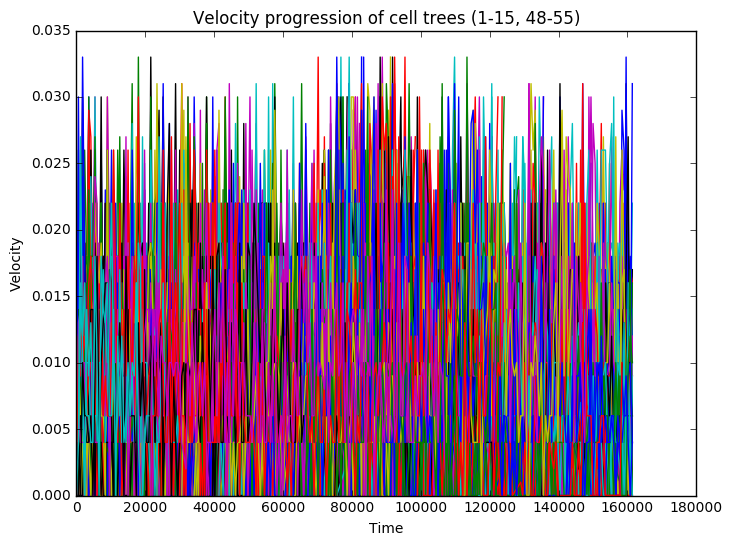

In [59]:
for pos in dat_f:
    for t in dat_f[pos]['TREES']:
    
        t_v = dat_f[pos]['TREES'][t]['VELOCITY']
        t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
        t_time = dat_f[pos]['TREES'][t]['POSITION_T']
        t_ds = dat_f[pos]['TREES'][t]['CASPASE']

        for br in t_time:
            this_v = t_v[br]
            this_time = t_time[br]
            this_ds = t_ds[br]
            this_v = np.array(this_v)
            this_ds = np.array(this_ds)
            pt.plot(this_time, this_v)

pt.title("Velocity progression of cell trees (1-15, 48-55)")
pt.ylabel("Velocity")
pt.xlabel("Time")
pt.gcf().set_size_inches(8, 6)

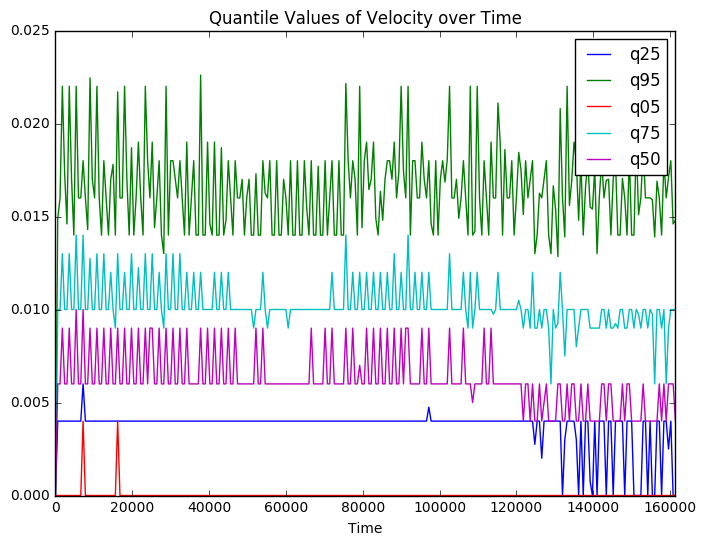

In [60]:
xmin = float('inf')
xmax = -float('inf')
ymin = float('inf')
ymax = -float('inf')

xdat = []
ydat = []

for pos in dat_f:
    for t in dat_f[pos]['TREES']:
    
        t_v = dat_f[pos]['TREES'][t]['VELOCITY']
        t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
        t_time = dat_f[pos]['TREES'][t]['POSITION_T']
        t_ds = dat_f[pos]['TREES'][t]['VELOCITY']

        for br in t_time:
            this_v = np.array(t_v[br])
            this_time = np.array(t_time[br])
            this_ds = np.array(t_ds[br])
            this_v = np.array(this_v)
            this_ds = np.array(this_ds)
            
            x = this_time[~np.isnan(this_ds)]
            y = this_v[~np.isnan(this_ds)]
            
            xdat = xdat + list(x)
            ydat = ydat + list(y)
            
xy = pd.DataFrame({'X': xdat, 'Y':ydat})

vals = {'q05': xy.groupby(['X'])['Y'].quantile(q=0.05),
        'q25': xy.groupby(['X'])['Y'].quantile(q=0.25),
        'q50': xy.groupby(['X'])['Y'].quantile(q=0.50),
        'q75': xy.groupby(['X'])['Y'].quantile(q=0.75),
        'q95': xy.groupby(['X'])['Y'].quantile(q=0.95)}

x = xy.groupby(['X'])['X'].first().tolist()
for qt in vals:
    pt.plot(x, vals[qt], label=qt)

            
pt.title("Quantile Values of Velocity over Time")
pt.xlabel("Time")

# limit plot range
pt.xlim(min(x), max(x))

pt.legend(loc='best')

pt.gcf().set_size_inches(8, 6)

## III.3 Global intensity analysis

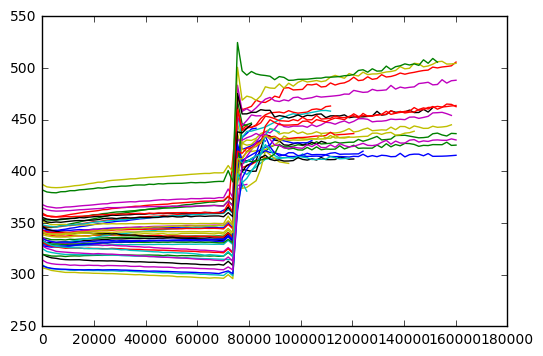

In [151]:
for pos in dat_f:
    
    ## finds the tree yielding the longest measurement time
    tr = [t for t in dat_f[pos]['TREES']]
    t1 = [list(dat_f[pos]['TREES'][t]['BRANCH'].values())[0][0] for t in dat_f[pos]['TREES']]
    t2 = [list(dat_f[pos]['TREES'][t]['BRANCH'].values())[0][1] for t in dat_f[pos]['TREES']]
    t1 = [dat_f[pos]['TREES'][tr]['POSITION_T'][br][-1] for tr, br in zip(tr, t1)]
    t2 = [dat_f[pos]['TREES'][tr]['POSITION_T'][br][-1] for tr, br in zip(tr, t2)]
    
    tmax = [max(tm1, tm2) for tm1, tm2 in zip(t1, t2)]
    
    if len(tmax) > 0:
        
        ## tree yielding the longest measurement time
        tr = tr[np.argmax(tmax)]
        
        ## extract values
        pos_time = dat_f[pos]['TREES'][tr]['POSITION_T'][tr]
        pos_pi = dat_f[pos]['TREES'][tr]['PI'][tr]
        pos_pinorm = dat_f[pos]['TREES'][tr]['PI_NORM'][tr]
        
        br1 = dat_f[pos]['TREES'][tr]['BRANCH'][tr][0]
        br1_time = dat_f[pos]['TREES'][tr]['POSITION_T'][br1][-1]
        br2 = dat_f[pos]['TREES'][tr]['BRANCH'][tr][1]
        br2_time = dat_f[pos]['TREES'][tr]['POSITION_T'][br2][-1]
        
        if br1_time <= br2_time: 
            
            pos_time = pos_time + dat_f[pos]['TREES'][tr]['POSITION_T'][br1]
            pos_pi = pos_pi + dat_f[pos]['TREES'][tr]['PI'][br1]
            pos_pinorm = pos_pinorm + dat_f[pos]['TREES'][tr]['PI_NORM'][br1]
            
        else:
            
            pos_time = pos_time + dat_f[pos]['TREES'][tr]['POSITION_T'][br2]
            pos_pi = pos_pi + dat_f[pos]['TREES'][tr]['PI'][br2]
            pos_pinorm = pos_pinorm + dat_f[pos]['TREES'][tr]['PI_NORM'][br2]
            
        pos_time = np.array(pos_time)
        pos_time = pos_time[~np.isnan(pos_pinorm)]
        pos_pi = np.array(pos_pi)
        pos_pi = pos_pi[~np.isnan(pos_pinorm)]
        pos_pinorm = np.array(pos_pinorm)
        pos_pinorm = pos_pinorm[~np.isnan(pos_pinorm)]
        
#         print(pos, pos_time)
#         print(pos, pos_pinorm)
        
#         print(pos, pos_pi / pos_pinorm)
        pt.plot(pos_time, pos_pi / pos_pinorm)

### III.2 Correlation Analysis

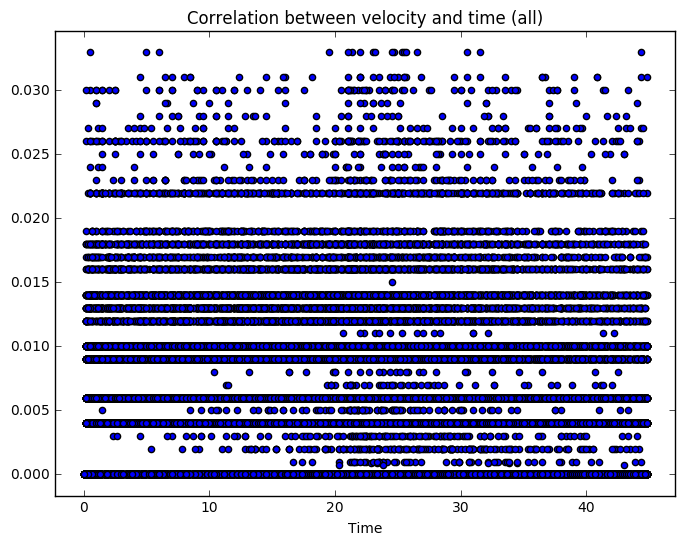

In [114]:
xmin = float('inf')
xmax = -float('inf')
ymin = float('inf')
ymax = -float('inf')

for pos in dat_f:
    for t in dat_f[pos]['TREES']:
    
        t_v = dat_f[pos]['TREES'][t]['VELOCITY']
        t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
        t_time = dat_f[pos]['TREES'][t]['POSITION_T']
        t_ds = dat_f[pos]['TREES'][t]['VELOCITY']

        for br in t_time:
            this_v = np.array(t_v[br])
            this_time = np.array(t_time[br])
            this_ds = np.array(t_ds[br])
            this_v = np.array(this_v)
            this_ds = np.array(this_ds)
            
            x = this_time[~np.isnan(this_ds)]
            x = x / 3600.
            y = this_v[~np.isnan(this_ds)]
            pt.scatter(x, y)
            
            if x.size > 0:
                ## update max and min
                xmin = min(xmin, min(x))
                xmax = max(xmax, max(x))
                ymin = min(ymin, min(y))
                ymax = max(ymax, max(y))

pt.title("Correlation between velocity and time (all)")
pt.xlabel("Time")

# limit plot range
pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

pt.gcf().set_size_inches(8, 6)

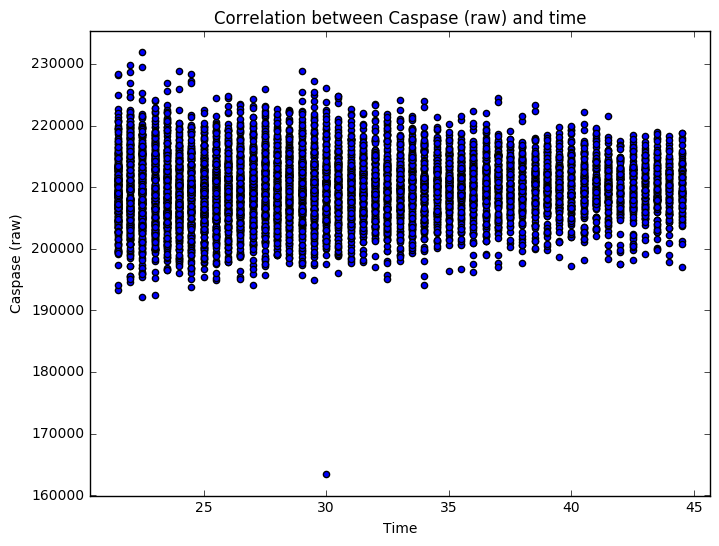

In [113]:
xmin = float('inf')
xmax = -float('inf')
ymin = float('inf')
ymax = -float('inf')

for pos in dat_f:
    for t in dat_f[pos]['TREES']:
    
        t_v = dat_f[pos]['TREES'][t]['VELOCITY']
        t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
        t_time = dat_f[pos]['TREES'][t]['POSITION_T']
        t_ds = dat_f[pos]['TREES'][t]['CASPASE']

        for br in t_time:
            this_v = np.array(t_v[br])
            this_time = np.array(t_time[br])
            this_ds = np.array(t_ds[br])
            this_v = np.array(this_v)
            this_ds = np.array(this_ds)
            
            x = this_time[~np.isnan(this_ds)]
            x = x / 3600.
            y = this_ds[~np.isnan(this_ds)]
            pt.scatter(x, y)
            
            if x.size > 0:
                ## update max and min
                xmin = min(xmin, min(x))
                xmax = max(xmax, max(x))
                ymin = min(ymin, min(y))
                ymax = max(ymax, max(y))

pt.title("Correlation between Caspase (raw) and time")
pt.ylabel("Caspase (raw)")
pt.xlabel("Time")

# limit plot range
pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

pt.gcf().set_size_inches(8, 6)

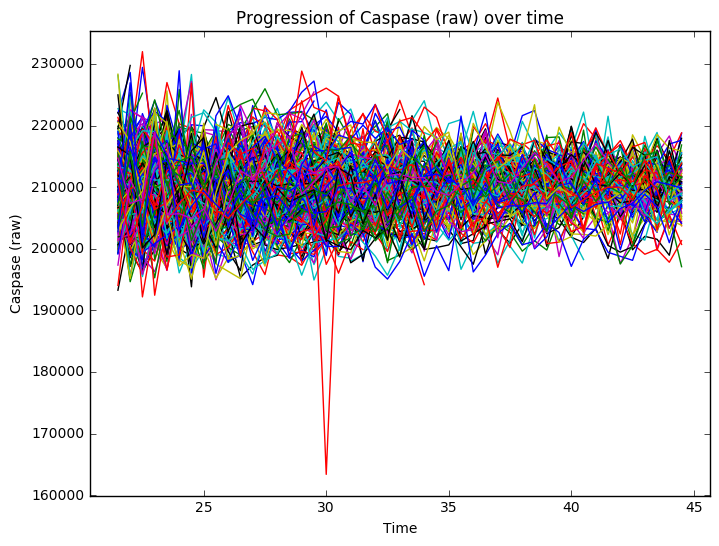

In [116]:
xmin = float('inf')
xmax = -float('inf')
ymin = float('inf')
ymax = -float('inf')

for pos in dat_f:
    for t in dat_f[pos]['TREES']:
    
        t_v = dat_f[pos]['TREES'][t]['VELOCITY']
        t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
        t_time = dat_f[pos]['TREES'][t]['POSITION_T']
        t_ds = dat_f[pos]['TREES'][t]['CASPASE']

        for br in t_time:
            this_v = np.array(t_v[br])
            this_time = np.array(t_time[br])
            this_ds = np.array(t_ds[br])
            this_v = np.array(this_v)
            this_ds = np.array(this_ds)
            
            x = this_time[~np.isnan(this_ds)]
            x = x / 3600.
            y = this_ds[~np.isnan(this_ds)]
#             pt.scatter(x, y)
            pt.plot(x, y)
            
            if x.size > 0:
                ## update max and min
                xmin = min(xmin, min(x))
                xmax = max(xmax, max(x))
                ymin = min(ymin, min(y))
                ymax = max(ymax, max(y))

pt.title("Progression of Caspase (raw) over time")
pt.ylabel("Caspase (raw)")
pt.xlabel("Time")

# limit plot range
pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

pt.gcf().set_size_inches(8, 6)

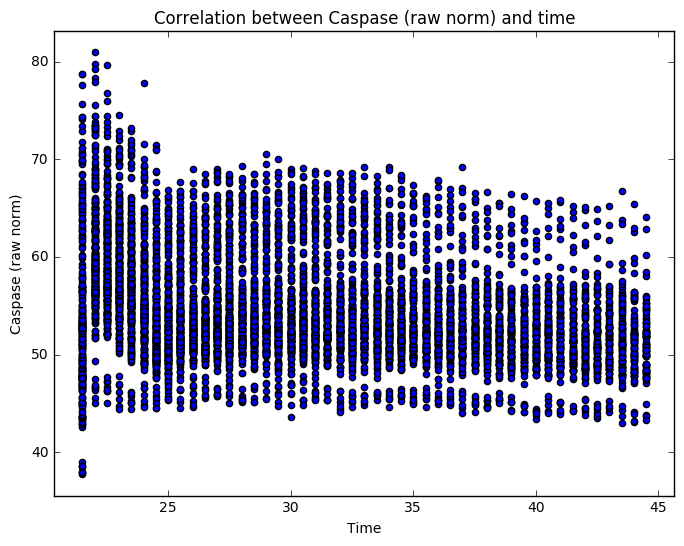

In [112]:
xmin = float('inf')
xmax = -float('inf')
ymin = float('inf')
ymax = -float('inf')

for pos in dat_f:
    for t in dat_f[pos]['TREES']:
    
        t_v = dat_f[pos]['TREES'][t]['VELOCITY']
        t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
        t_time = dat_f[pos]['TREES'][t]['POSITION_T']
        t_ds = dat_f[pos]['TREES'][t]['CASPASE_NORM']

        for br in t_time:
            this_v = np.array(t_v[br])
            this_time = np.array(t_time[br])
            this_ds = np.array(t_ds[br])
            this_v = np.array(this_v)
            this_ds = np.array(this_ds)
            
            x = this_time[~np.isnan(this_ds)]
            x = x / 3600.
            y = this_ds[~np.isnan(this_ds)]
            pt.scatter(x, y)
            
            if x.size > 0:
                ## update max and min
                xmin = min(xmin, min(x))
                xmax = max(xmax, max(x))
                ymin = min(ymin, min(y))
                ymax = max(ymax, max(y))

pt.title("Correlation between Caspase (raw norm) and time")
pt.ylabel("Caspase (raw norm)")
pt.xlabel("Time")

# limit plot range
pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

pt.gcf().set_size_inches(8, 6)

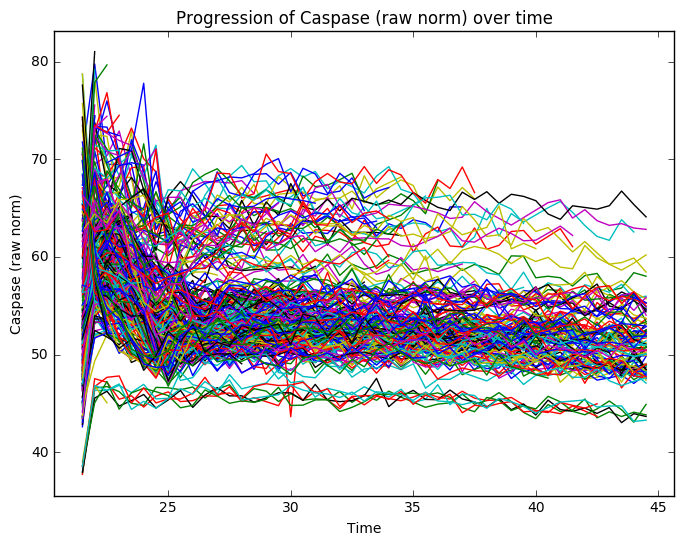

In [117]:
xmin = float('inf')
xmax = -float('inf')
ymin = float('inf')
ymax = -float('inf')

for pos in dat_f:
    for t in dat_f[pos]['TREES']:
    
        t_v = dat_f[pos]['TREES'][t]['VELOCITY']
        t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
        t_time = dat_f[pos]['TREES'][t]['POSITION_T']
        t_ds = dat_f[pos]['TREES'][t]['CASPASE_NORM']

        for br in t_time:
            this_v = np.array(t_v[br])
            this_time = np.array(t_time[br])
            this_ds = np.array(t_ds[br])
            this_v = np.array(this_v)
            this_ds = np.array(this_ds)
            
            x = this_time[~np.isnan(this_ds)]
            x = x / 3600.
            y = this_ds[~np.isnan(this_ds)]
            pt.plot(x, y)
            
            if x.size > 0:
                ## update max and min
                xmin = min(xmin, min(x))
                xmax = max(xmax, max(x))
                ymin = min(ymin, min(y))
                ymax = max(ymax, max(y))

pt.title("Progression of Caspase (raw norm) over time")
pt.ylabel("Caspase (raw norm)")
pt.xlabel("Time")

# limit plot range
pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

pt.gcf().set_size_inches(8, 6)

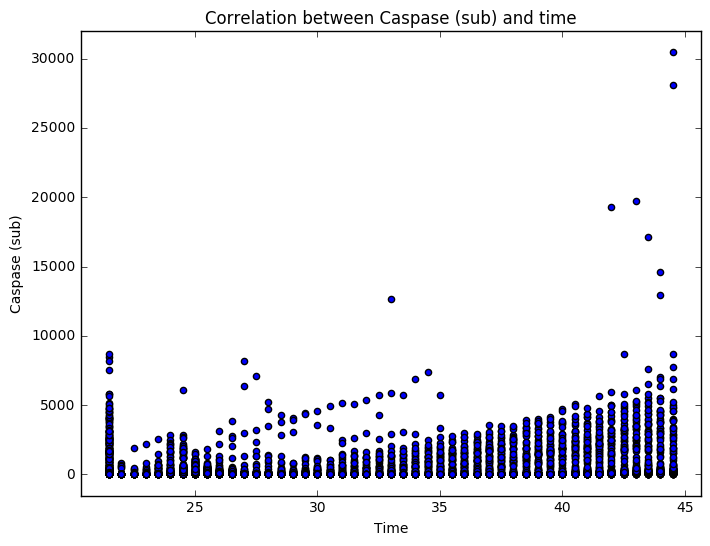

In [111]:
xmin = float('inf')
xmax = -float('inf')
ymin = float('inf')
ymax = -float('inf')

for pos in dat_f:
    for t in dat_f[pos]['TREES']:
    
        t_v = dat_f[pos]['TREES'][t]['VELOCITY']
        t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
        t_time = dat_f[pos]['TREES'][t]['POSITION_T']
        t_ds = dat_f[pos]['TREES'][t]['CASPASE_SUB']

        for br in t_time:
            this_v = np.array(t_v[br])
            this_time = np.array(t_time[br])
            this_ds = np.array(t_ds[br])
            this_v = np.array(this_v)
            this_ds = np.array(this_ds)
            
            x = this_time[~np.isnan(this_ds)]
            x = x / 3600.
            y = this_ds[~np.isnan(this_ds)]
            pt.scatter(x, y)
            
            if x.size > 0:
                ## update max and min
                xmin = min(xmin, min(x))
                xmax = max(xmax, max(x))
                ymin = min(ymin, min(y))
                ymax = max(ymax, max(y))

pt.title("Correlation between Caspase (sub) and time")
pt.ylabel("Caspase (sub)")
pt.xlabel("Time")

# limit plot range
pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

pt.gcf().set_size_inches(8, 6)

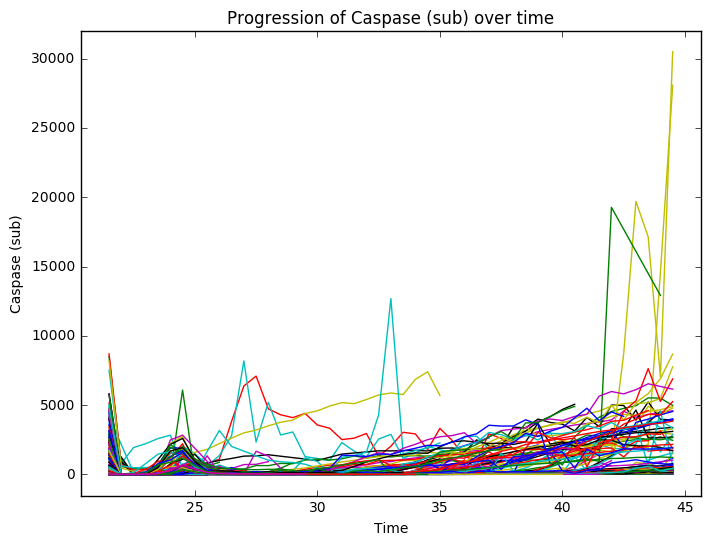

In [118]:
xmin = float('inf')
xmax = -float('inf')
ymin = float('inf')
ymax = -float('inf')

for pos in dat_f:
    for t in dat_f[pos]['TREES']:
    
        t_v = dat_f[pos]['TREES'][t]['VELOCITY']
        t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
        t_time = dat_f[pos]['TREES'][t]['POSITION_T']
        t_ds = dat_f[pos]['TREES'][t]['CASPASE_SUB']

        for br in t_time:
            this_v = np.array(t_v[br])
            this_time = np.array(t_time[br])
            this_ds = np.array(t_ds[br])
            this_v = np.array(this_v)
            this_ds = np.array(this_ds)
            
            x = this_time[~np.isnan(this_ds)]
            x = x / 3600.
            y = this_ds[~np.isnan(this_ds)]
#             pt.scatter(x, y)
            pt.plot(x, y)
            
            if x.size > 0:
                ## update max and min
                xmin = min(xmin, min(x))
                xmax = max(xmax, max(x))
                ymin = min(ymin, min(y))
                ymax = max(ymax, max(y))

pt.title("Progression of Caspase (sub) over time")
pt.ylabel("Caspase (sub)")
pt.xlabel("Time")

# limit plot range
pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

pt.gcf().set_size_inches(8, 6)

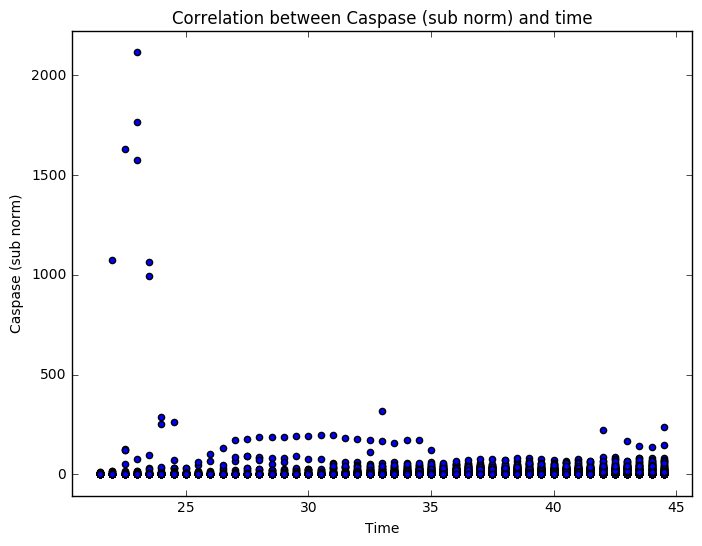

In [110]:
xmin = float('inf')
xmax = -float('inf')
ymin = float('inf')
ymax = -float('inf')

for pos in dat_f:
    for t in dat_f[pos]['TREES']:
    
        t_v = dat_f[pos]['TREES'][t]['VELOCITY']
        t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
        t_time = dat_f[pos]['TREES'][t]['POSITION_T']
        t_ds = dat_f[pos]['TREES'][t]['CASPASE_SUB_NORM']

        for br in t_time:
            this_v = np.array(t_v[br])
            this_time = np.array(t_time[br])
            this_ds = np.array(t_ds[br])
            this_v = np.array(this_v)
            this_ds = np.array(this_ds)
            
            x = this_time[~np.isnan(this_ds)]
            x = x / 3600.
            y = this_ds[~np.isnan(this_ds)]
            pt.scatter(x, y)
            
            if x.size > 0:
                ## update max and min
                xmin = min(xmin, min(x))
                xmax = max(xmax, max(x))
                ymin = min(ymin, min(y))
                ymax = max(ymax, max(y))

pt.title("Correlation between Caspase (sub norm) and time")
pt.ylabel("Caspase (sub norm)")
pt.xlabel("Time")

# limit plot range
pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

pt.gcf().set_size_inches(8, 6)

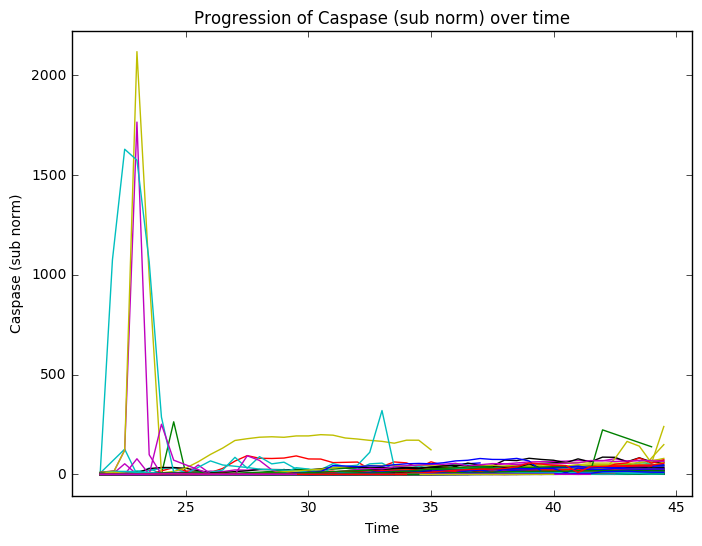

In [120]:
xmin = float('inf')
xmax = -float('inf')
ymin = float('inf')
ymax = -float('inf')

for pos in dat_f:
    for t in dat_f[pos]['TREES']:
    
        t_v = dat_f[pos]['TREES'][t]['VELOCITY']
        t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
        t_time = dat_f[pos]['TREES'][t]['POSITION_T']
        t_ds = dat_f[pos]['TREES'][t]['CASPASE_SUB_NORM']

        for br in t_time:
            this_v = np.array(t_v[br])
            this_time = np.array(t_time[br])
            this_ds = np.array(t_ds[br])
            this_v = np.array(this_v)
            this_ds = np.array(this_ds)
            
            x = this_time[~np.isnan(this_ds)]
            x = x / 3600.
            y = this_ds[~np.isnan(this_ds)]
            pt.plot(x, y)
            
            if x.size > 0:
                ## update max and min
                xmin = min(xmin, min(x))
                xmax = max(xmax, max(x))
                ymin = min(ymin, min(y))
                ymax = max(ymax, max(y))

pt.title("Progression of Caspase (sub norm) over time")
pt.ylabel("Caspase (sub norm)")
pt.xlabel("Time")

# limit plot range
pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

pt.gcf().set_size_inches(8, 6)

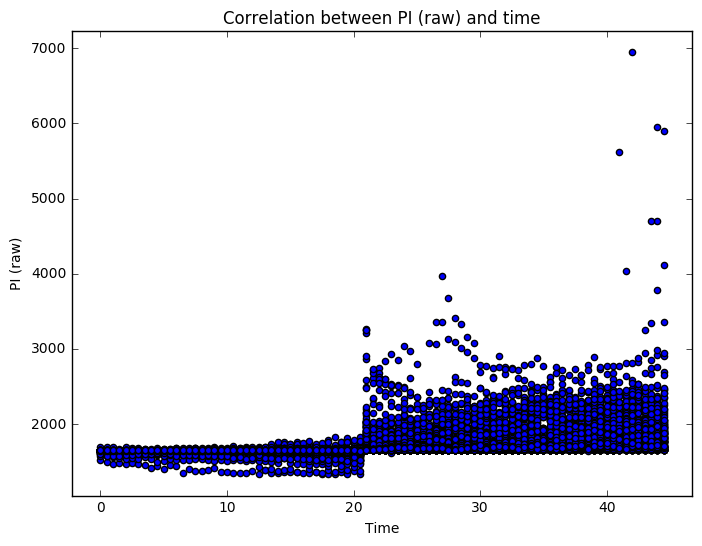

In [109]:
xmin = float('inf')
xmax = -float('inf')
ymin = float('inf')
ymax = -float('inf')

for pos in dat_f:
    for t in dat_f[pos]['TREES']:
    
        t_v = dat_f[pos]['TREES'][t]['VELOCITY']
        t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
        t_time = dat_f[pos]['TREES'][t]['POSITION_T']
        t_ds = dat_f[pos]['TREES'][t]['PI']

        for br in t_time:
            this_v = np.array(t_v[br])
            this_time = np.array(t_time[br])
            this_ds = np.array(t_ds[br])
            this_v = np.array(this_v)
            this_ds = np.array(this_ds)
            
            x = this_time[~np.isnan(this_ds)]
            x = x / 3600.
            y = this_ds[~np.isnan(this_ds)]
            pt.scatter(x, y)
            
            if x.size > 0:
                ## update max and min
                xmin = min(xmin, min(x))
                xmax = max(xmax, max(x))
                ymin = min(ymin, min(y))
                ymax = max(ymax, max(y))

pt.title("Correlation between PI (raw) and time")
pt.ylabel("PI (raw)")
pt.xlabel("Time")

# limit plot range
pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

pt.gcf().set_size_inches(8, 6)

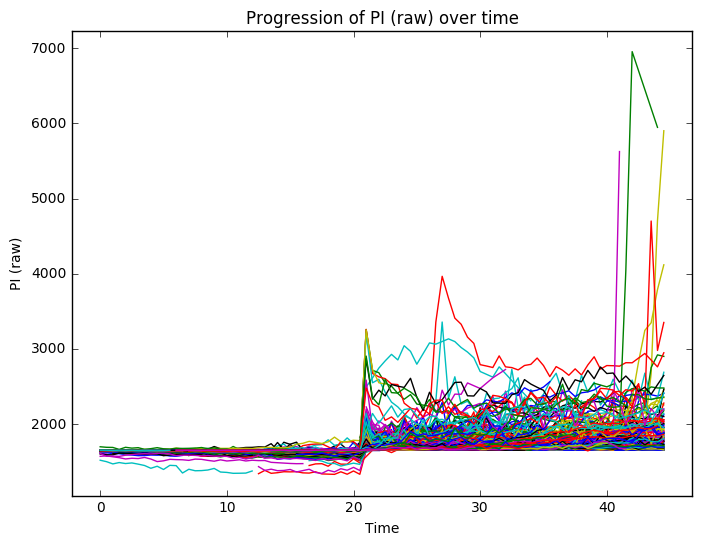

In [121]:
xmin = float('inf')
xmax = -float('inf')
ymin = float('inf')
ymax = -float('inf')

for pos in dat_f:
    for t in dat_f[pos]['TREES']:
    
        t_v = dat_f[pos]['TREES'][t]['VELOCITY']
        t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
        t_time = dat_f[pos]['TREES'][t]['POSITION_T']
        t_ds = dat_f[pos]['TREES'][t]['PI']

        for br in t_time:
            this_v = np.array(t_v[br])
            this_time = np.array(t_time[br])
            this_ds = np.array(t_ds[br])
            this_v = np.array(this_v)
            this_ds = np.array(this_ds)
            
            x = this_time[~np.isnan(this_ds)]
            x = x / 3600.
            y = this_ds[~np.isnan(this_ds)]
            pt.plot(x, y)
            
            if x.size > 0:
                ## update max and min
                xmin = min(xmin, min(x))
                xmax = max(xmax, max(x))
                ymin = min(ymin, min(y))
                ymax = max(ymax, max(y))

pt.title("Progression of PI (raw) over time")
pt.ylabel("PI (raw)")
pt.xlabel("Time")

# limit plot range
pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

pt.gcf().set_size_inches(8, 6)

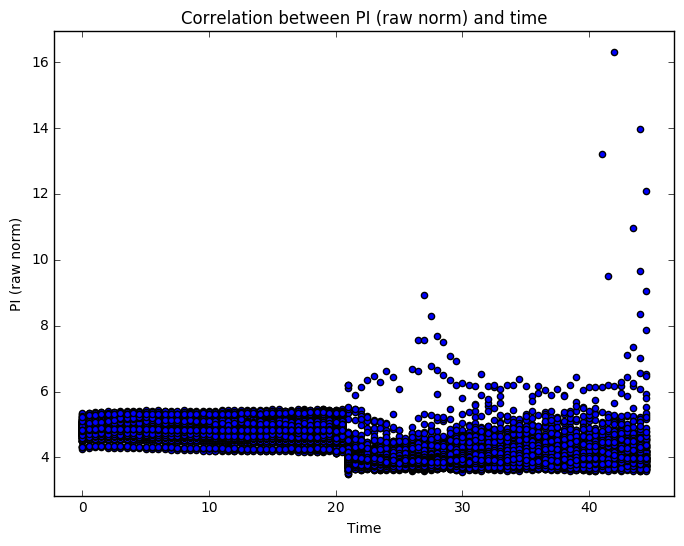

In [108]:
xmin = float('inf')
xmax = -float('inf')
ymin = float('inf')
ymax = -float('inf')

for pos in dat_f:
    for t in dat_f[pos]['TREES']:
    
        t_v = dat_f[pos]['TREES'][t]['VELOCITY']
        t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
        t_time = dat_f[pos]['TREES'][t]['POSITION_T']
        t_ds = dat_f[pos]['TREES'][t]['PI_NORM']

        for br in t_time:
            this_v = np.array(t_v[br])
            this_time = np.array(t_time[br])
            this_ds = np.array(t_ds[br])
            this_v = np.array(this_v)
            this_ds = np.array(this_ds)
            
            x = this_time[~np.isnan(this_ds)]
            x = x / 3600.
            y = this_ds[~np.isnan(this_ds)]
            pt.scatter(x, y)
            
            if x.size > 0:
                ## update max and min
                xmin = min(xmin, min(x))
                xmax = max(xmax, max(x))
                ymin = min(ymin, min(y))
                ymax = max(ymax, max(y))

pt.title("Correlation between PI (raw norm) and time")
pt.ylabel("PI (raw norm)")
pt.xlabel("Time")

# limit plot range
pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

pt.gcf().set_size_inches(8, 6)

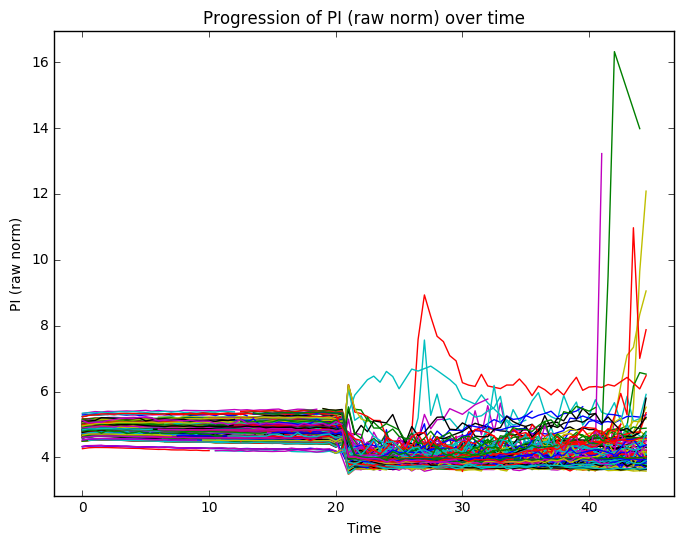

In [122]:
xmin = float('inf')
xmax = -float('inf')
ymin = float('inf')
ymax = -float('inf')

for pos in dat_f:
    for t in dat_f[pos]['TREES']:
    
        t_v = dat_f[pos]['TREES'][t]['VELOCITY']
        t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
        t_time = dat_f[pos]['TREES'][t]['POSITION_T']
        t_ds = dat_f[pos]['TREES'][t]['PI_NORM']

        for br in t_time:
            this_v = np.array(t_v[br])
            this_time = np.array(t_time[br])
            this_ds = np.array(t_ds[br])
            this_v = np.array(this_v)
            this_ds = np.array(this_ds)
            
            x = this_time[~np.isnan(this_ds)]
            x = x / 3600.
            y = this_ds[~np.isnan(this_ds)]
            pt.plot(x, y)
            
            if x.size > 0:
                ## update max and min
                xmin = min(xmin, min(x))
                xmax = max(xmax, max(x))
                ymin = min(ymin, min(y))
                ymax = max(ymax, max(y))

pt.title("Progression of PI (raw norm) over time")
pt.ylabel("PI (raw norm)")
pt.xlabel("Time")

# limit plot range
pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

pt.gcf().set_size_inches(8, 6)

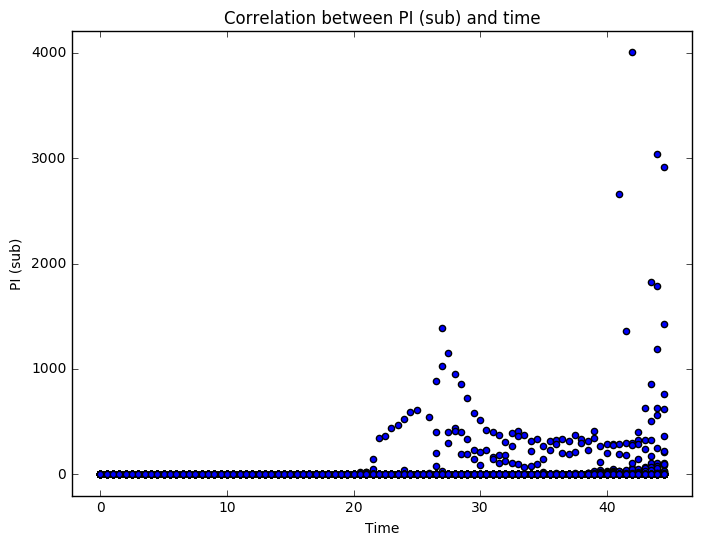

In [107]:
xmin = float('inf')
xmax = -float('inf')
ymin = float('inf')
ymax = -float('inf')

for pos in dat_f:
    for t in dat_f[pos]['TREES']:
    
        t_v = dat_f[pos]['TREES'][t]['VELOCITY']
        t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
        t_time = dat_f[pos]['TREES'][t]['POSITION_T']
        t_ds = dat_f[pos]['TREES'][t]['PI_SUB']

        for br in t_time:
            this_v = np.array(t_v[br])
            this_time = np.array(t_time[br])
            this_ds = np.array(t_ds[br])
            this_v = np.array(this_v)
            this_ds = np.array(this_ds)
            
            x = this_time[~np.isnan(this_ds)]
            x = x / 3600.
            y = this_ds[~np.isnan(this_ds)]
            pt.scatter(x, y)
            
            if x.size > 0:
                ## update max and min
                xmin = min(xmin, min(x))
                xmax = max(xmax, max(x))
                ymin = min(ymin, min(y))
                ymax = max(ymax, max(y))

pt.title("Correlation between PI (sub) and time")
pt.ylabel("PI (sub)")
pt.xlabel("Time")

# limit plot range
pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

pt.gcf().set_size_inches(8, 6)

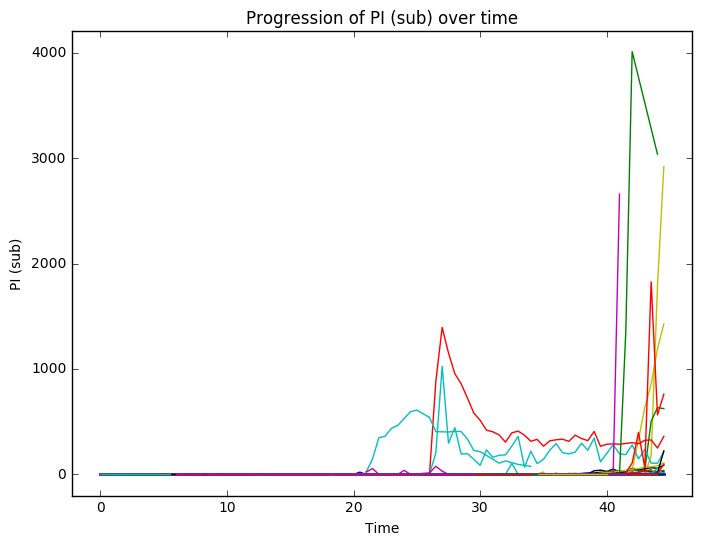

In [123]:
xmin = float('inf')
xmax = -float('inf')
ymin = float('inf')
ymax = -float('inf')

for pos in dat_f:
    for t in dat_f[pos]['TREES']:
    
        t_v = dat_f[pos]['TREES'][t]['VELOCITY']
        t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
        t_time = dat_f[pos]['TREES'][t]['POSITION_T']
        t_ds = dat_f[pos]['TREES'][t]['PI_SUB']

        for br in t_time:
            this_v = np.array(t_v[br])
            this_time = np.array(t_time[br])
            this_ds = np.array(t_ds[br])
            this_v = np.array(this_v)
            this_ds = np.array(this_ds)
            
            x = this_time[~np.isnan(this_ds)]
            x = x / 3600.
            y = this_ds[~np.isnan(this_ds)]
            pt.plot(x, y)
            
            if x.size > 0:
                ## update max and min
                xmin = min(xmin, min(x))
                xmax = max(xmax, max(x))
                ymin = min(ymin, min(y))
                ymax = max(ymax, max(y))

pt.title("Progression of PI (sub) over time")
pt.ylabel("PI (sub)")
pt.xlabel("Time")

# limit plot range
pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

pt.gcf().set_size_inches(8, 6)

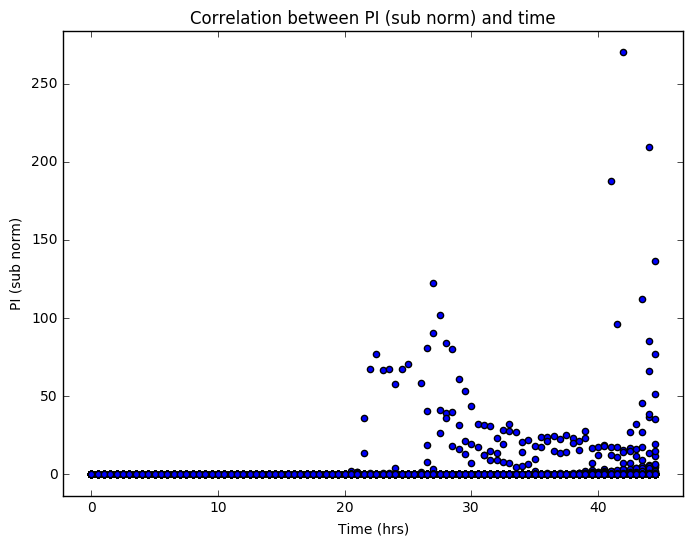

In [106]:
xmin = float('inf')
xmax = -float('inf')
ymin = float('inf')
ymax = -float('inf')

for pos in dat_f:
    for t in dat_f[pos]['TREES']:
    
        t_v = dat_f[pos]['TREES'][t]['VELOCITY']
        t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
        t_time = dat_f[pos]['TREES'][t]['POSITION_T']
        t_ds = dat_f[pos]['TREES'][t]['PI_SUB_NORM']

        for br in t_time:
            this_v = np.array(t_v[br])
            this_time = np.array(t_time[br])
            this_ds = np.array(t_ds[br])
            this_v = np.array(this_v)
            this_ds = np.array(this_ds)
            
            x = this_time[~np.isnan(this_ds)]
            x = x / 3600.
            y = this_ds[~np.isnan(this_ds)]
            pt.scatter(x, y)
            
            if x.size > 0:
                ## update max and min
                xmin = min(xmin, min(x))
                xmax = max(xmax, max(x))
                ymin = min(ymin, min(y))
                ymax = max(ymax, max(y))

pt.title("Correlation between PI (sub norm) and time")
pt.ylabel("PI (sub norm)")
pt.xlabel("Time (hrs)")

# limit plot range
pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

pt.gcf().set_size_inches(8, 6)

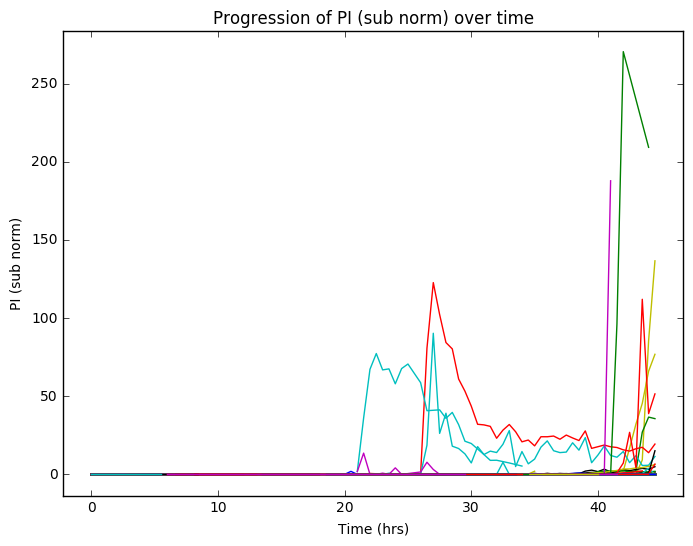

In [125]:
xmin = float('inf')
xmax = -float('inf')
ymin = float('inf')
ymax = -float('inf')

for pos in dat_f:
    for t in dat_f[pos]['TREES']:
    
        t_v = dat_f[pos]['TREES'][t]['VELOCITY']
        t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
        t_time = dat_f[pos]['TREES'][t]['POSITION_T']
        t_ds = dat_f[pos]['TREES'][t]['PI_SUB_NORM']

        for br in t_time:
            this_v = np.array(t_v[br])
            this_time = np.array(t_time[br])
            this_ds = np.array(t_ds[br])
            this_v = np.array(this_v)
            this_ds = np.array(this_ds)
            
            x = this_time[~np.isnan(this_ds)]
            x = x / 3600.
            y = this_ds[~np.isnan(this_ds)]
            pt.plot(x, y)
            
            if x.size > 0:
                ## update max and min
                xmin = min(xmin, min(x))
                xmax = max(xmax, max(x))
                ymin = min(ymin, min(y))
                ymax = max(ymax, max(y))

pt.title("Progression of PI (sub norm) over time")
pt.ylabel("PI (sub norm)")
pt.xlabel("Time (hrs)")

# limit plot range
pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

pt.gcf().set_size_inches(8, 6)

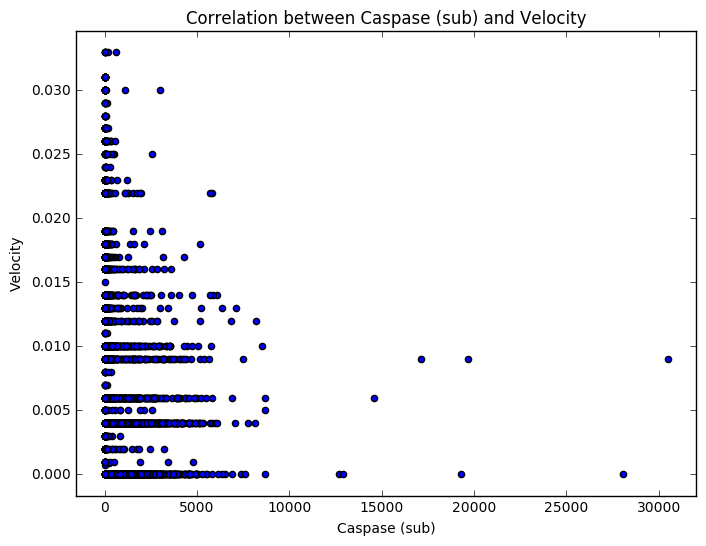

In [70]:
xmin = float('inf')
xmax = -float('inf')
ymin = float('inf')
ymax = -float('inf')

for pos in dat_f:
    for t in dat_f[pos]['TREES']:
    
        t_v = dat_f[pos]['TREES'][t]['VELOCITY']
        t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
        t_time = dat_f[pos]['TREES'][t]['POSITION_T']
        t_ds = dat_f[pos]['TREES'][t]['CASPASE_SUB']

        for br in t_time:
            this_v = np.array(t_v[br])
            this_time = np.array(t_time[br])
            this_ds = np.array(t_ds[br])
            this_v = np.array(this_v)
            this_ds = np.array(this_ds)
            
            x = this_ds[~np.isnan(this_ds)]
            y = this_v[~np.isnan(this_ds)]
            pt.scatter(x, y)
            
            if x.size > 0:
                ## update max and min
                xmin = min(xmin, min(x))
                xmax = max(xmax, max(x))
                ymin = min(ymin, min(y))
                ymax = max(ymax, max(y))

pt.title("Correlation between Caspase (sub) and Velocity")
pt.ylabel("Velocity")
pt.xlabel("Caspase (sub)")

# limit plot range
pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

pt.gcf().set_size_inches(8, 6)

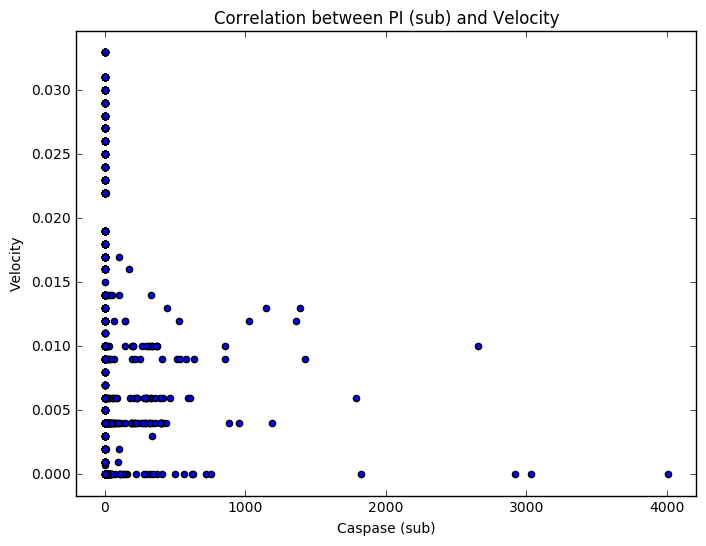

In [71]:
xmin = float('inf')
xmax = -float('inf')
ymin = float('inf')
ymax = -float('inf')

for pos in dat_f:
    for t in dat_f[pos]['TREES']:
    
        t_v = dat_f[pos]['TREES'][t]['VELOCITY']
        t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
        t_time = dat_f[pos]['TREES'][t]['POSITION_T']
        t_ds = dat_f[pos]['TREES'][t]['PI_SUB']

        for br in t_time:
            this_v = np.array(t_v[br])
            this_time = np.array(t_time[br])
            this_ds = np.array(t_ds[br])
            this_v = np.array(this_v)
            this_ds = np.array(this_ds)
            
            x = this_ds[~np.isnan(this_ds)]
            y = this_v[~np.isnan(this_ds)]
            pt.scatter(x, y)
            
            if x.size > 0:
                ## update max and min
                xmin = min(xmin, min(x))
                xmax = max(xmax, max(x))
                ymin = min(ymin, min(y))
                ymax = max(ymax, max(y))

pt.title("Correlation between PI (sub) and Velocity")
pt.ylabel("Velocity")
pt.xlabel("Caspase (sub)")

# limit plot range
pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

pt.gcf().set_size_inches(8, 6)

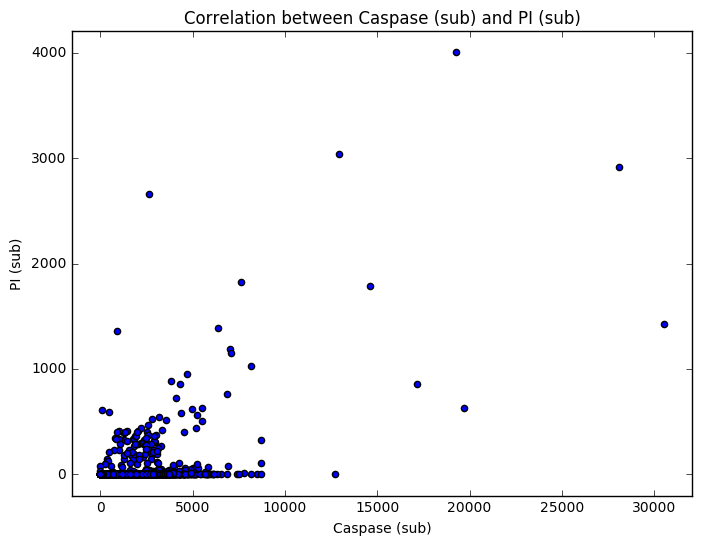

In [72]:
xmin = float('inf')
xmax = -float('inf')
ymin = float('inf')
ymax = -float('inf')

for pos in dat_f:
    for t in dat_f[pos]['TREES']:
    
        t_v = dat_f[pos]['TREES'][t]['VELOCITY']
        t_d = dat_f[pos]['TREES'][t]['DISPLACEMENT']
        t_time = dat_f[pos]['TREES'][t]['POSITION_T']
        t_ds1 = dat_f[pos]['TREES'][t]['CASPASE_SUB']
        t_ds2 = dat_f[pos]['TREES'][t]['PI_SUB']

        for br in t_time:
            this_v = np.array(t_v[br])
            this_time = np.array(t_time[br])
            this_ds1 = np.array(t_ds1[br])
            this_ds2 = np.array(t_ds2[br])
            this_v = np.array(this_v)
            this_ds = np.array(this_ds)
            
            x = this_ds1[~np.isnan(this_ds1)]
            y = this_ds2[~np.isnan(this_ds1)]
            pt.scatter(x, y)
            
            if x.size > 0:
                ## update max and min
                xmin = min(xmin, min(x))
                xmax = max(xmax, max(x))
                ymin = min(ymin, min(y))
                ymax = max(ymax, max(y))

pt.title("Correlation between Caspase (sub) and PI (sub)")
pt.ylabel("PI (sub)")
pt.xlabel("Caspase (sub)")

# limit plot range
pt.xlim(xmin - abs(xmax - xmin) * .05, xmax + abs(xmax - xmin) * .05)
pt.ylim(ymin - abs(ymax - ymin) * .05, ymax + abs(ymax - ymin) * .05)

pt.gcf().set_size_inches(8, 6)

## III.3 Correlation Analysis (treatment-basis)

In [73]:
invalid = set([4, 5, 11, 13, 19, 20, 37, 38, 44, 53, 54, 60])

In [74]:
trtmnt_1 = set(list(range(9)[1:])) - invalid
trtmnt_2 = set(list(range(16)[9:])) - invalid
trtmnt_3 = set(list(range(24)[16:])) - invalid
trtmnt_4 = set(list(range(32)[24:])) - invalid
trtmnt_5 = set(list(range(40)[32:])) - invalid
trtmnt_6 = set(list(range(48)[40:])) - invalid
trtmnt_7 = set(list(range(56)[48:])) - invalid
trtmnt_8 = set(list(range(64)[56:])) - invalid

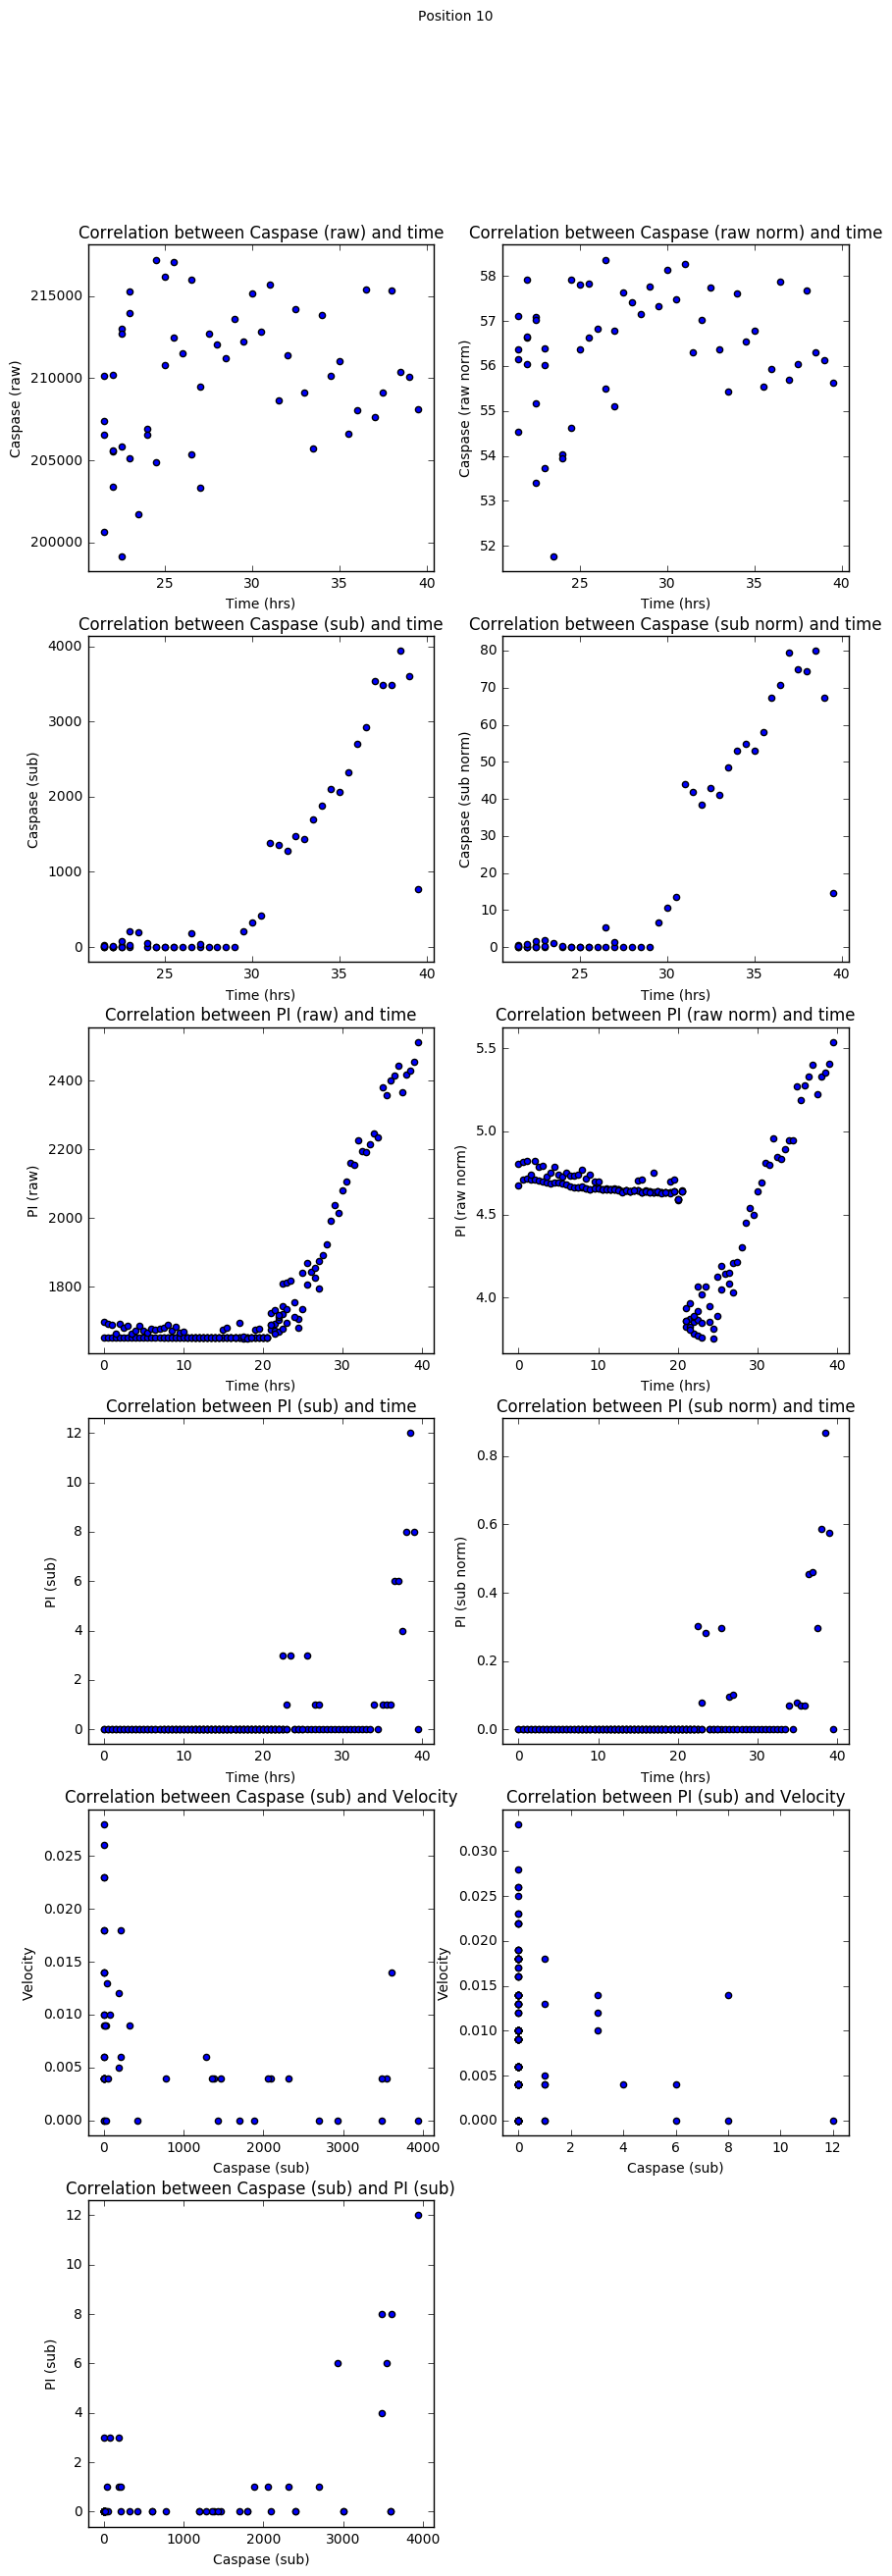

In [105]:
correlation_analysis_treatment(['10'], "Position 10", dat_f)

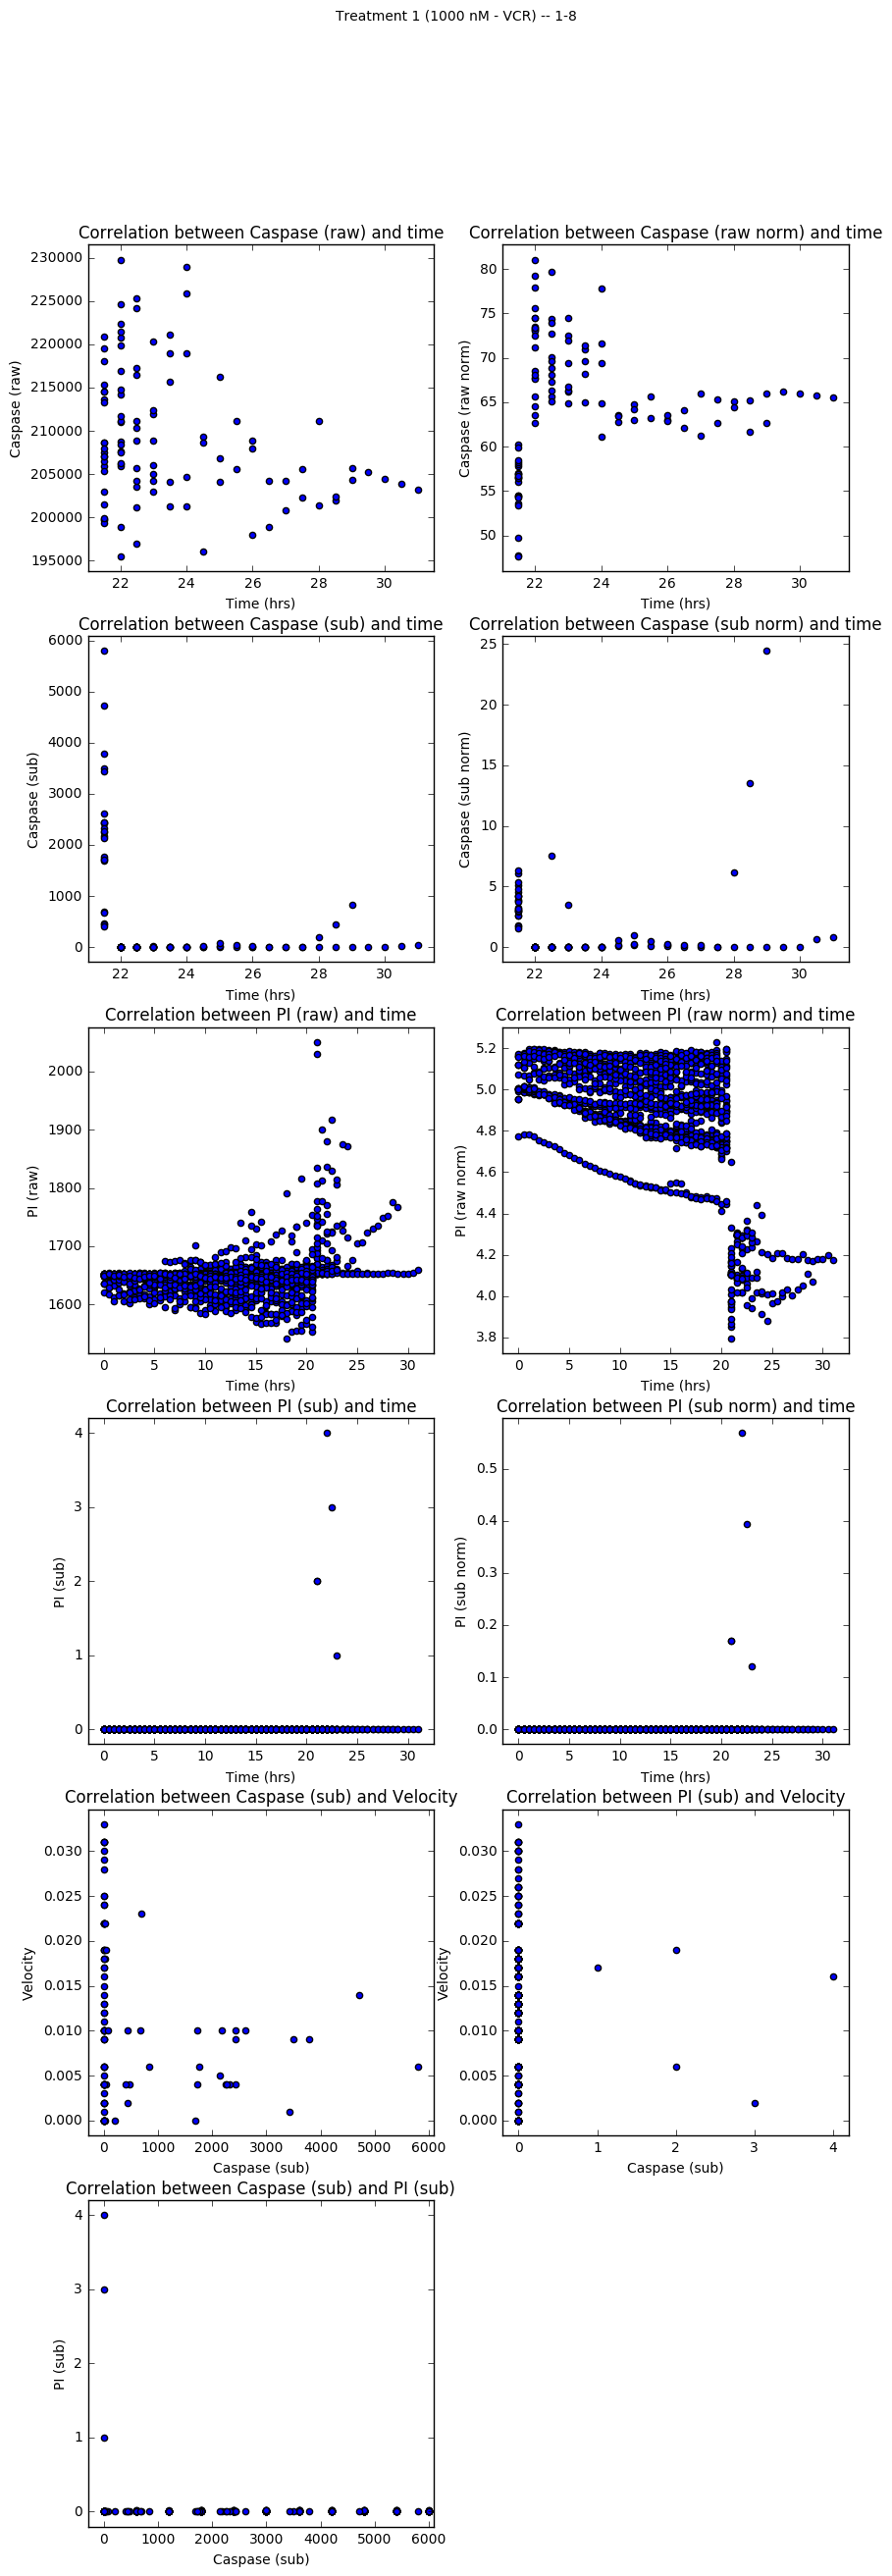

In [75]:
correlation_analysis_treatment([stringify_position(p) for p in trtmnt_1], "Treatment 1 (1000 nM - VCR) -- 1-8", dat_f)

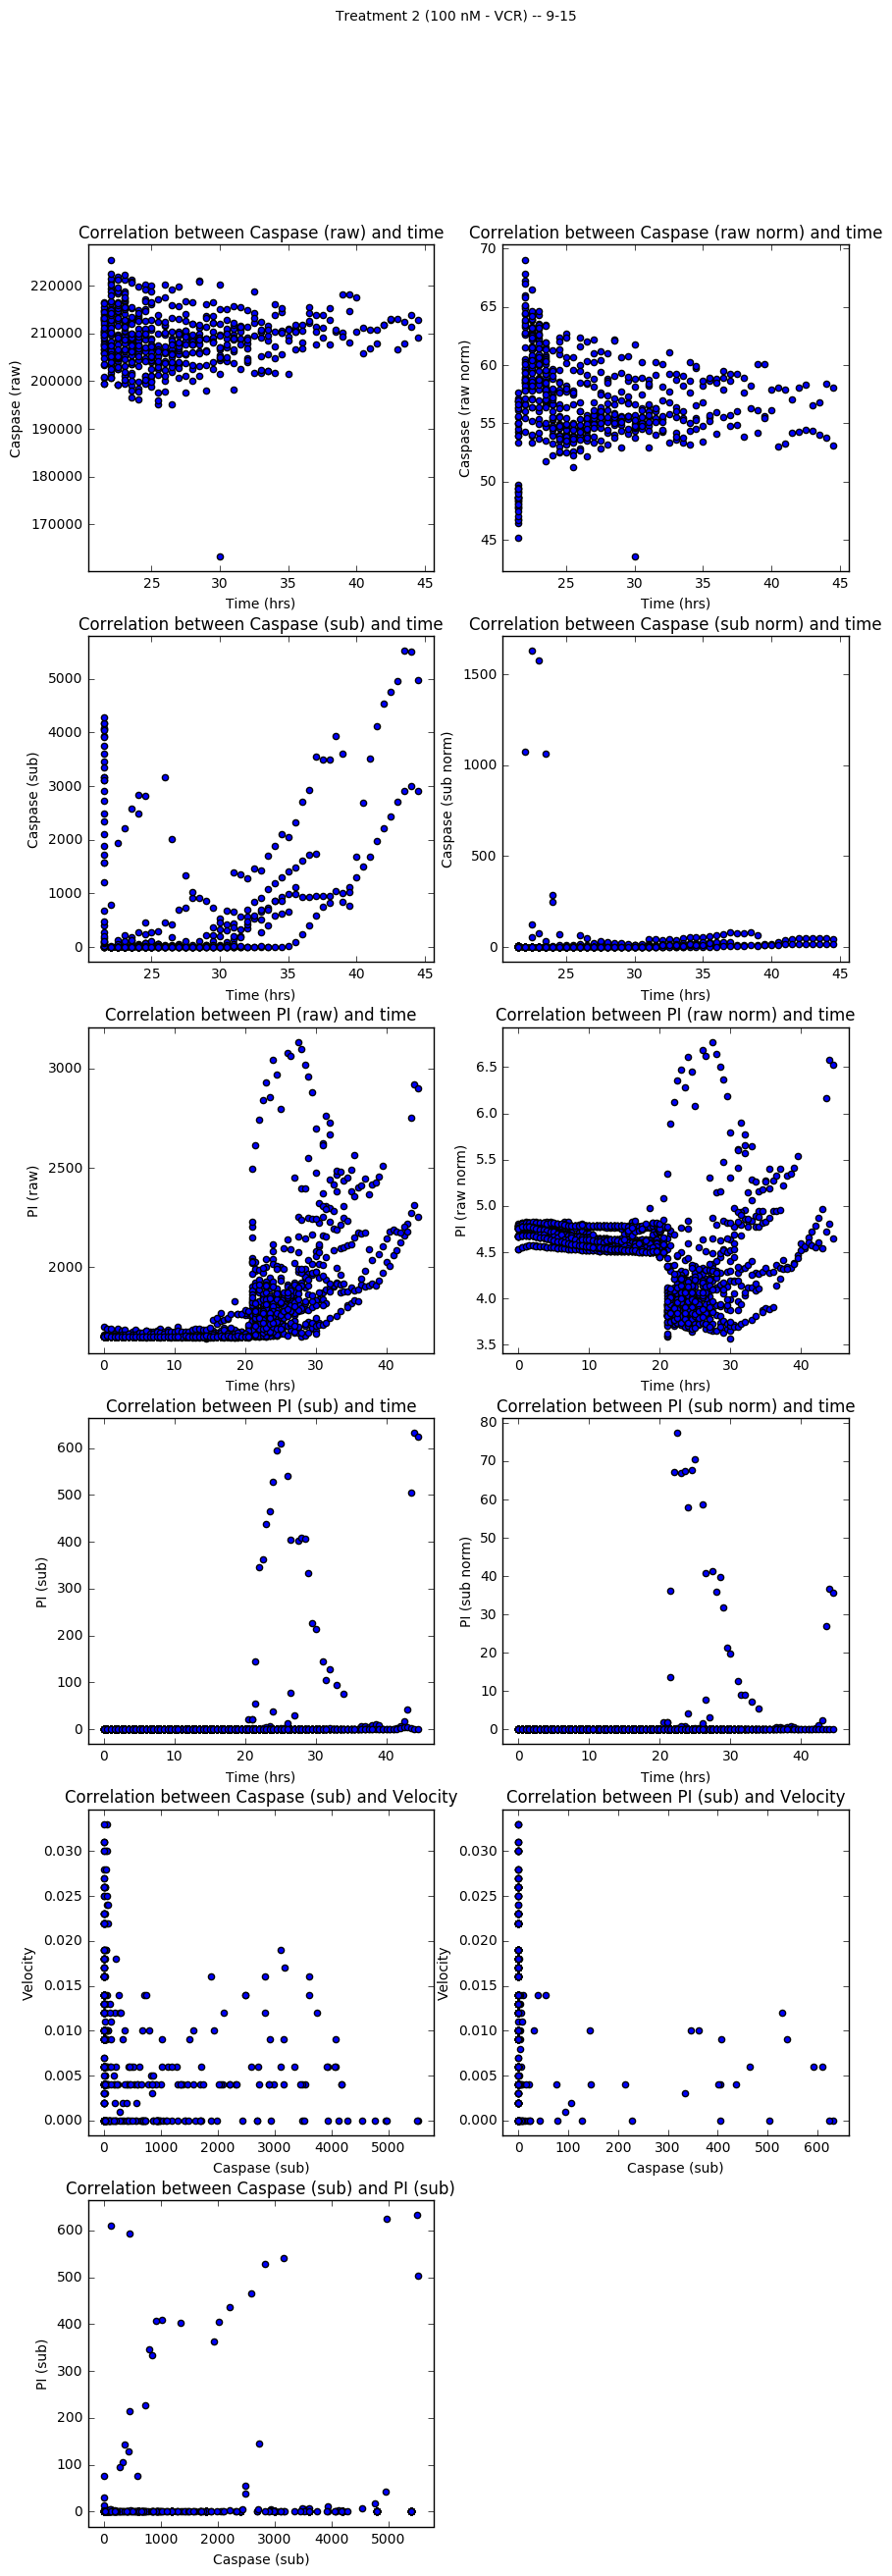

In [76]:
correlation_analysis_treatment([stringify_position(p) for p in trtmnt_2], "Treatment 2 (100 nM - VCR) -- 9-15", dat_f)

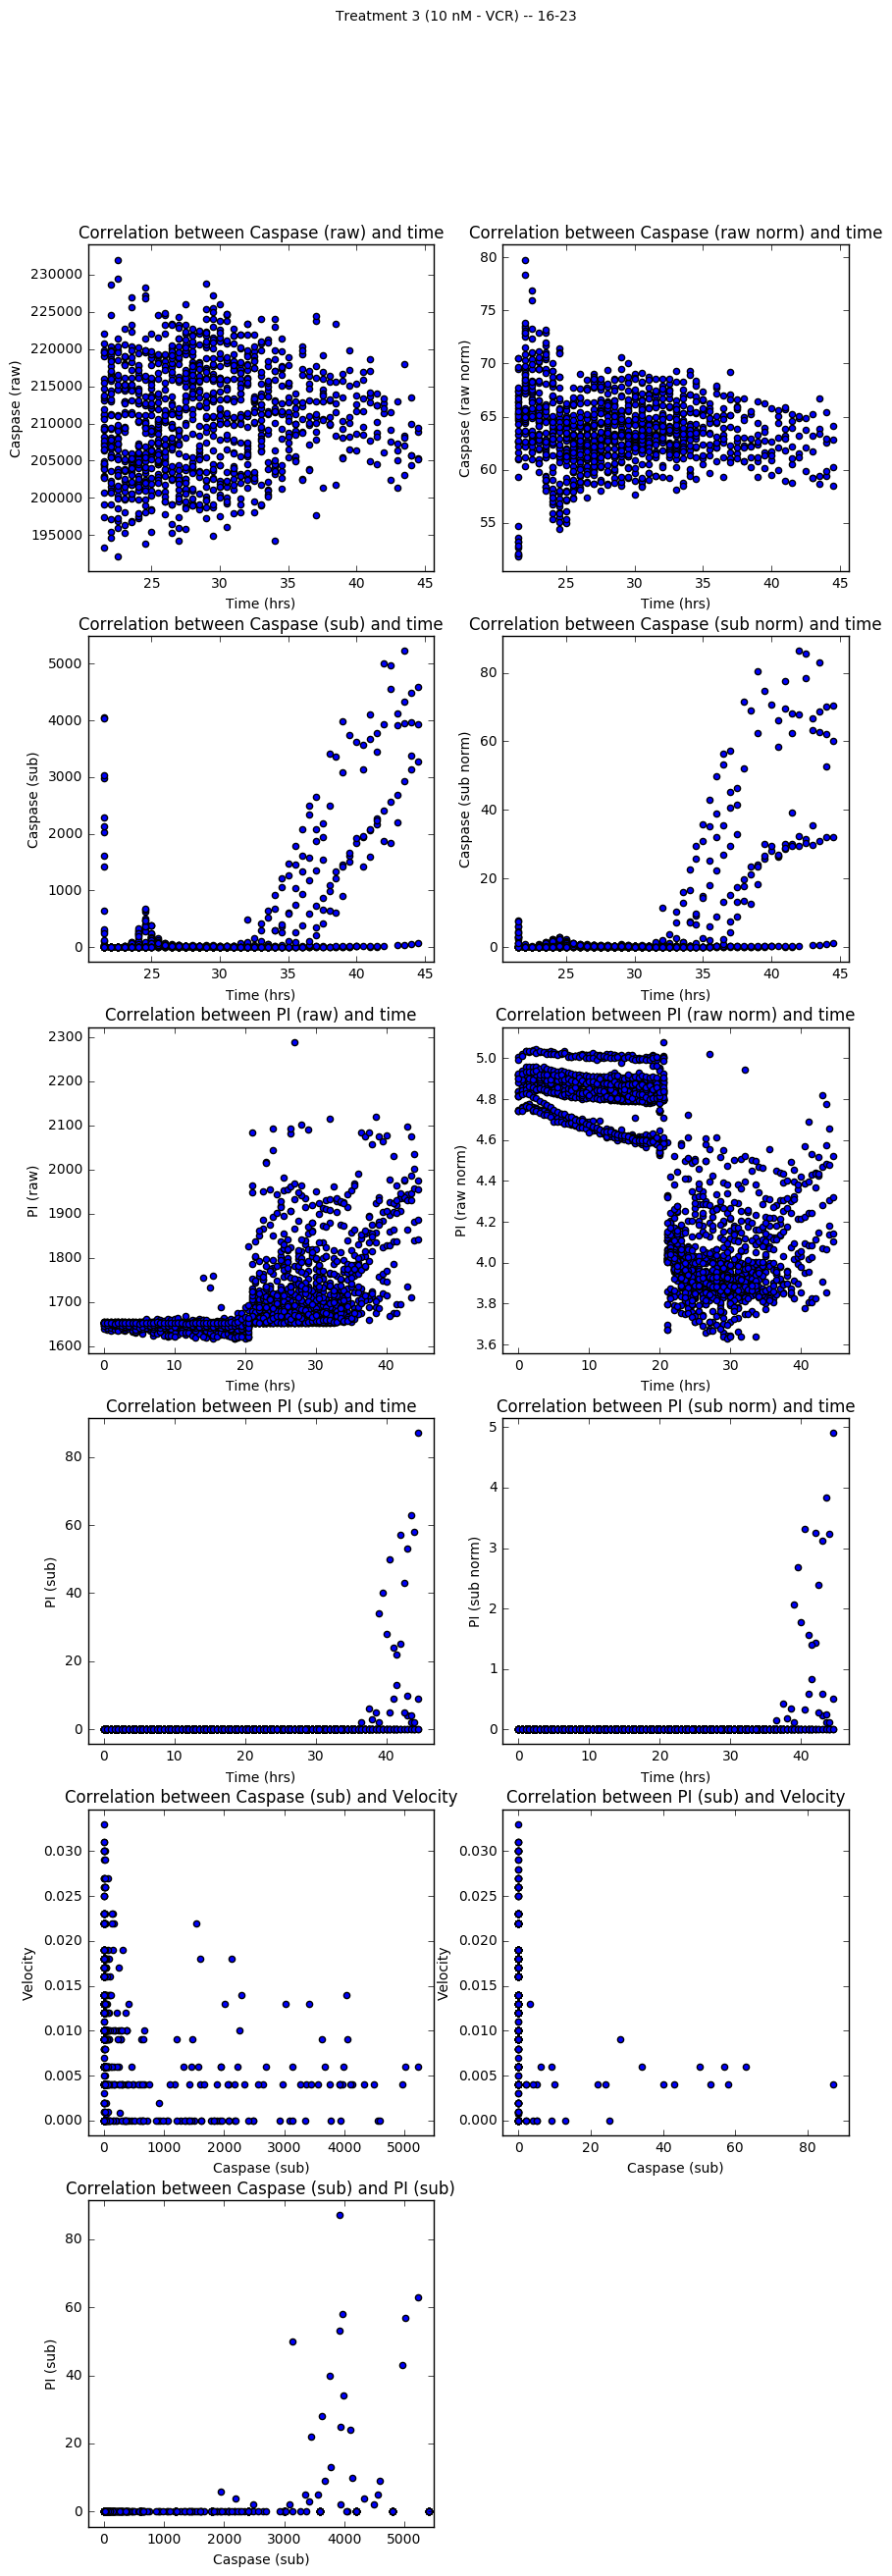

In [77]:
correlation_analysis_treatment([stringify_position(p) for p in trtmnt_3], "Treatment 3 (10 nM - VCR) -- 16-23", dat_f)

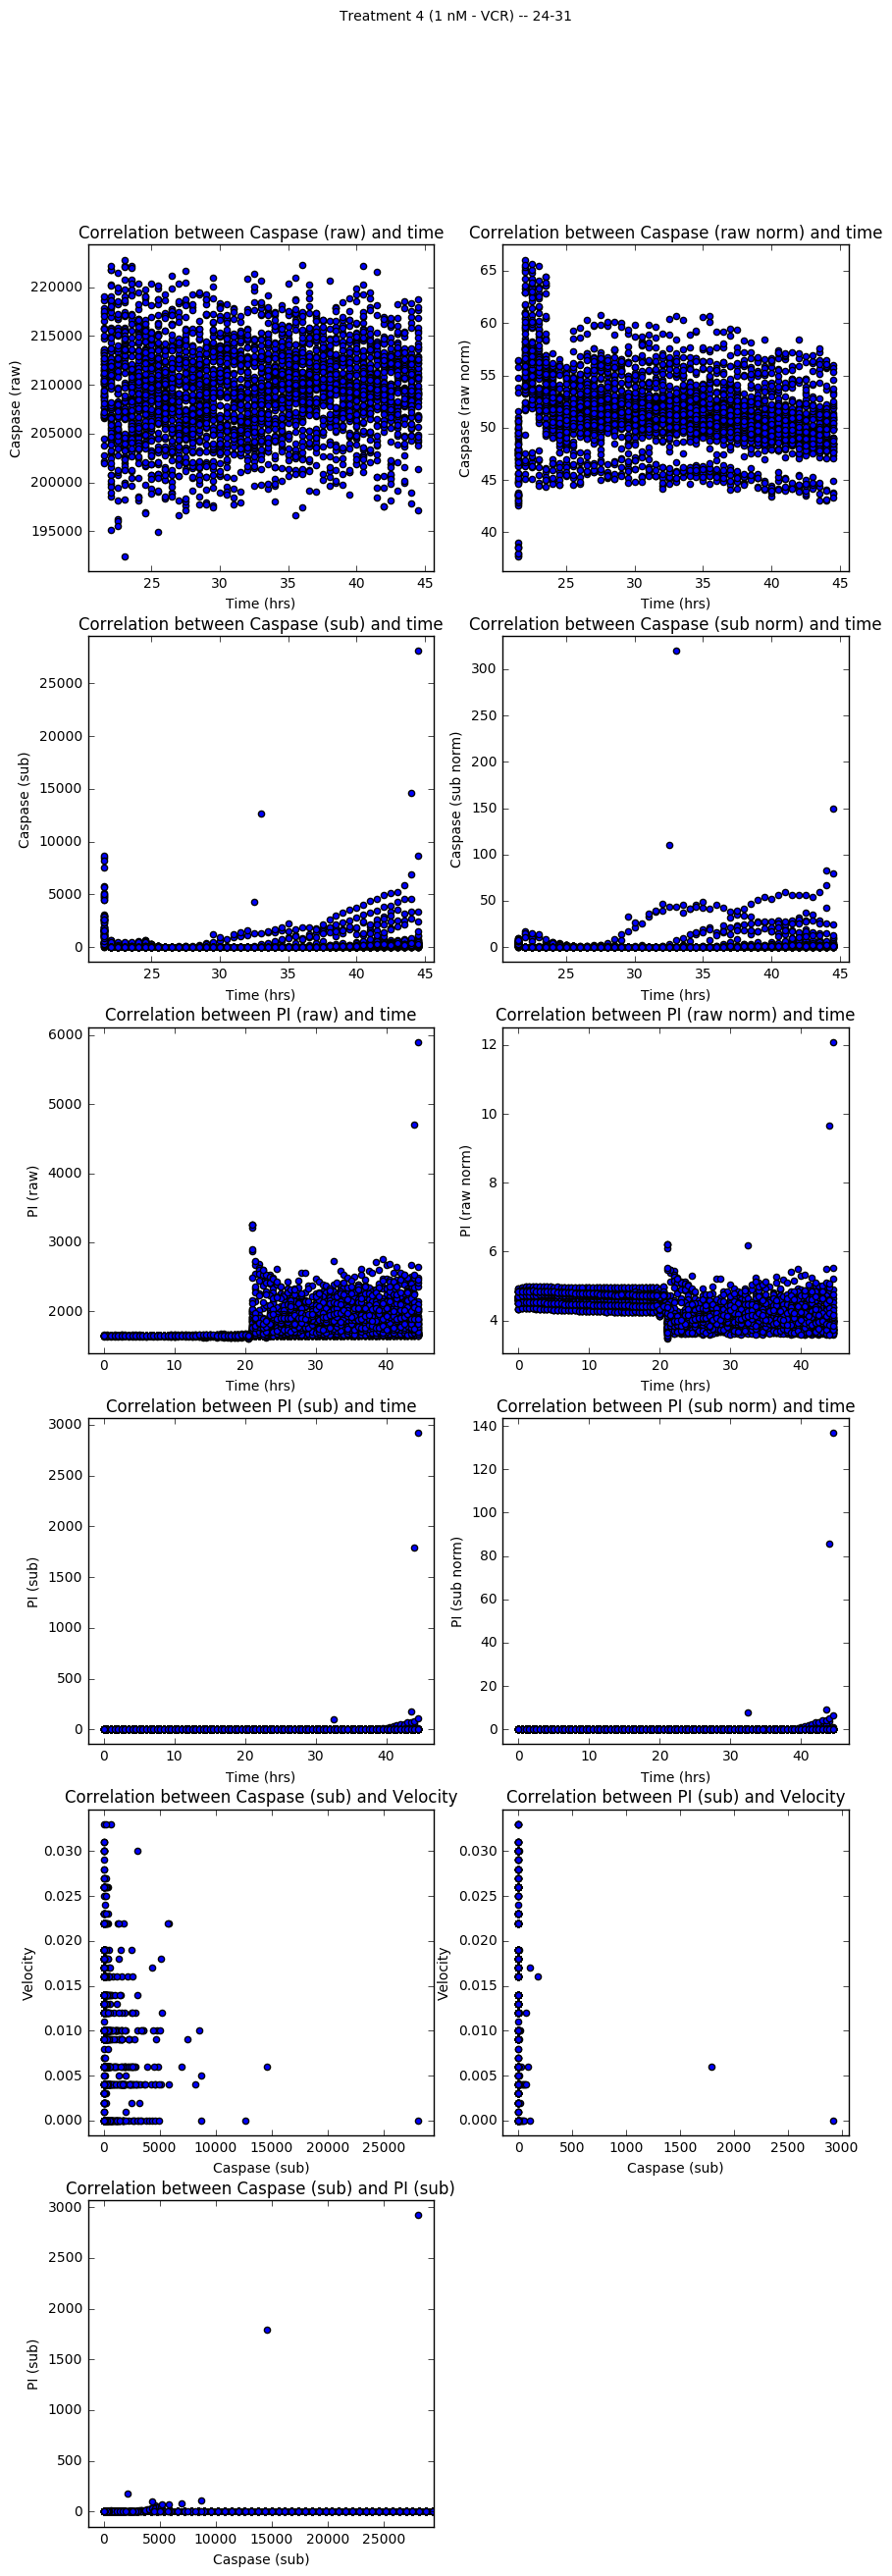

In [78]:
correlation_analysis_treatment([stringify_position(p) for p in trtmnt_4], "Treatment 4 (1 nM - VCR) -- 24-31", dat_f)

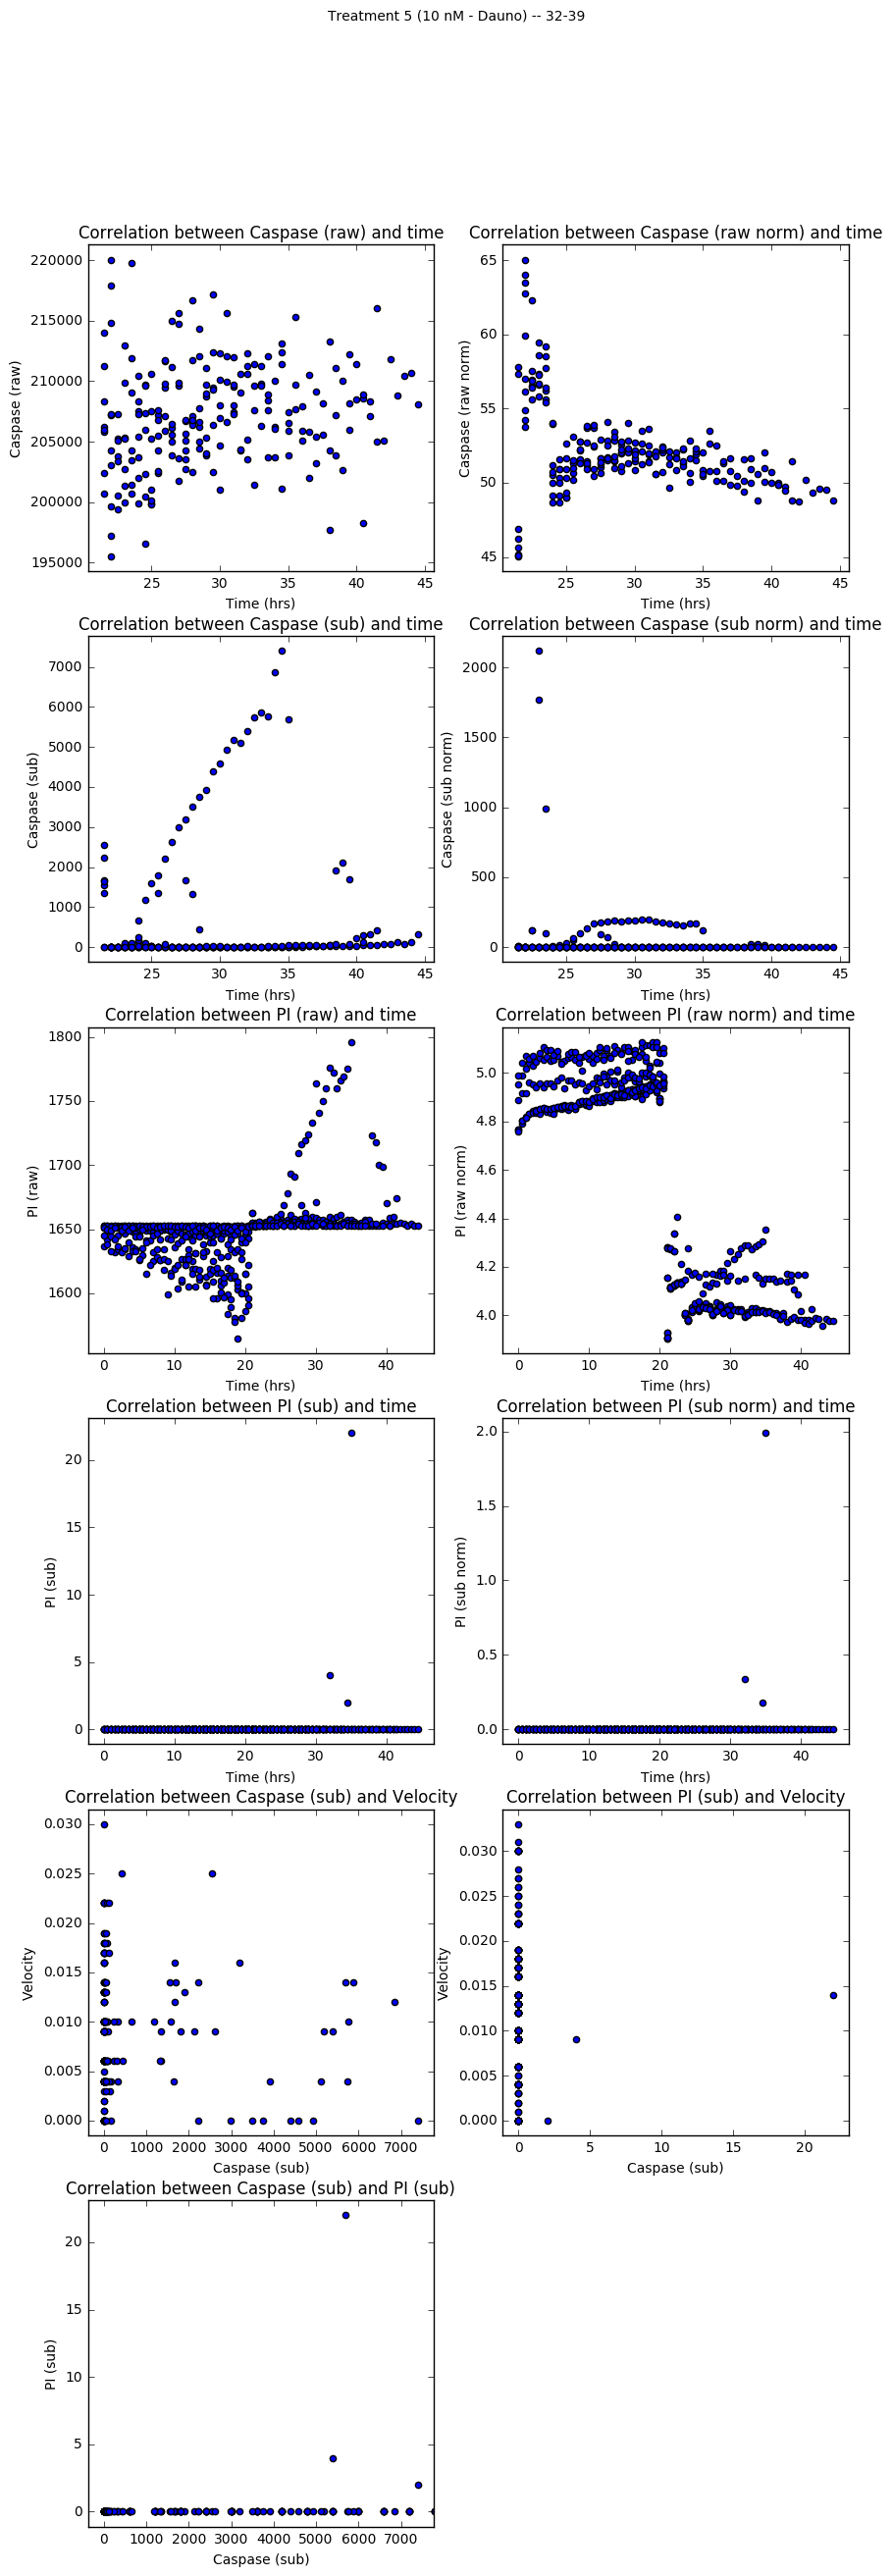

In [79]:
correlation_analysis_treatment([stringify_position(p) for p in trtmnt_5], "Treatment 5 (10 nM - Dauno) -- 32-39", dat_f)

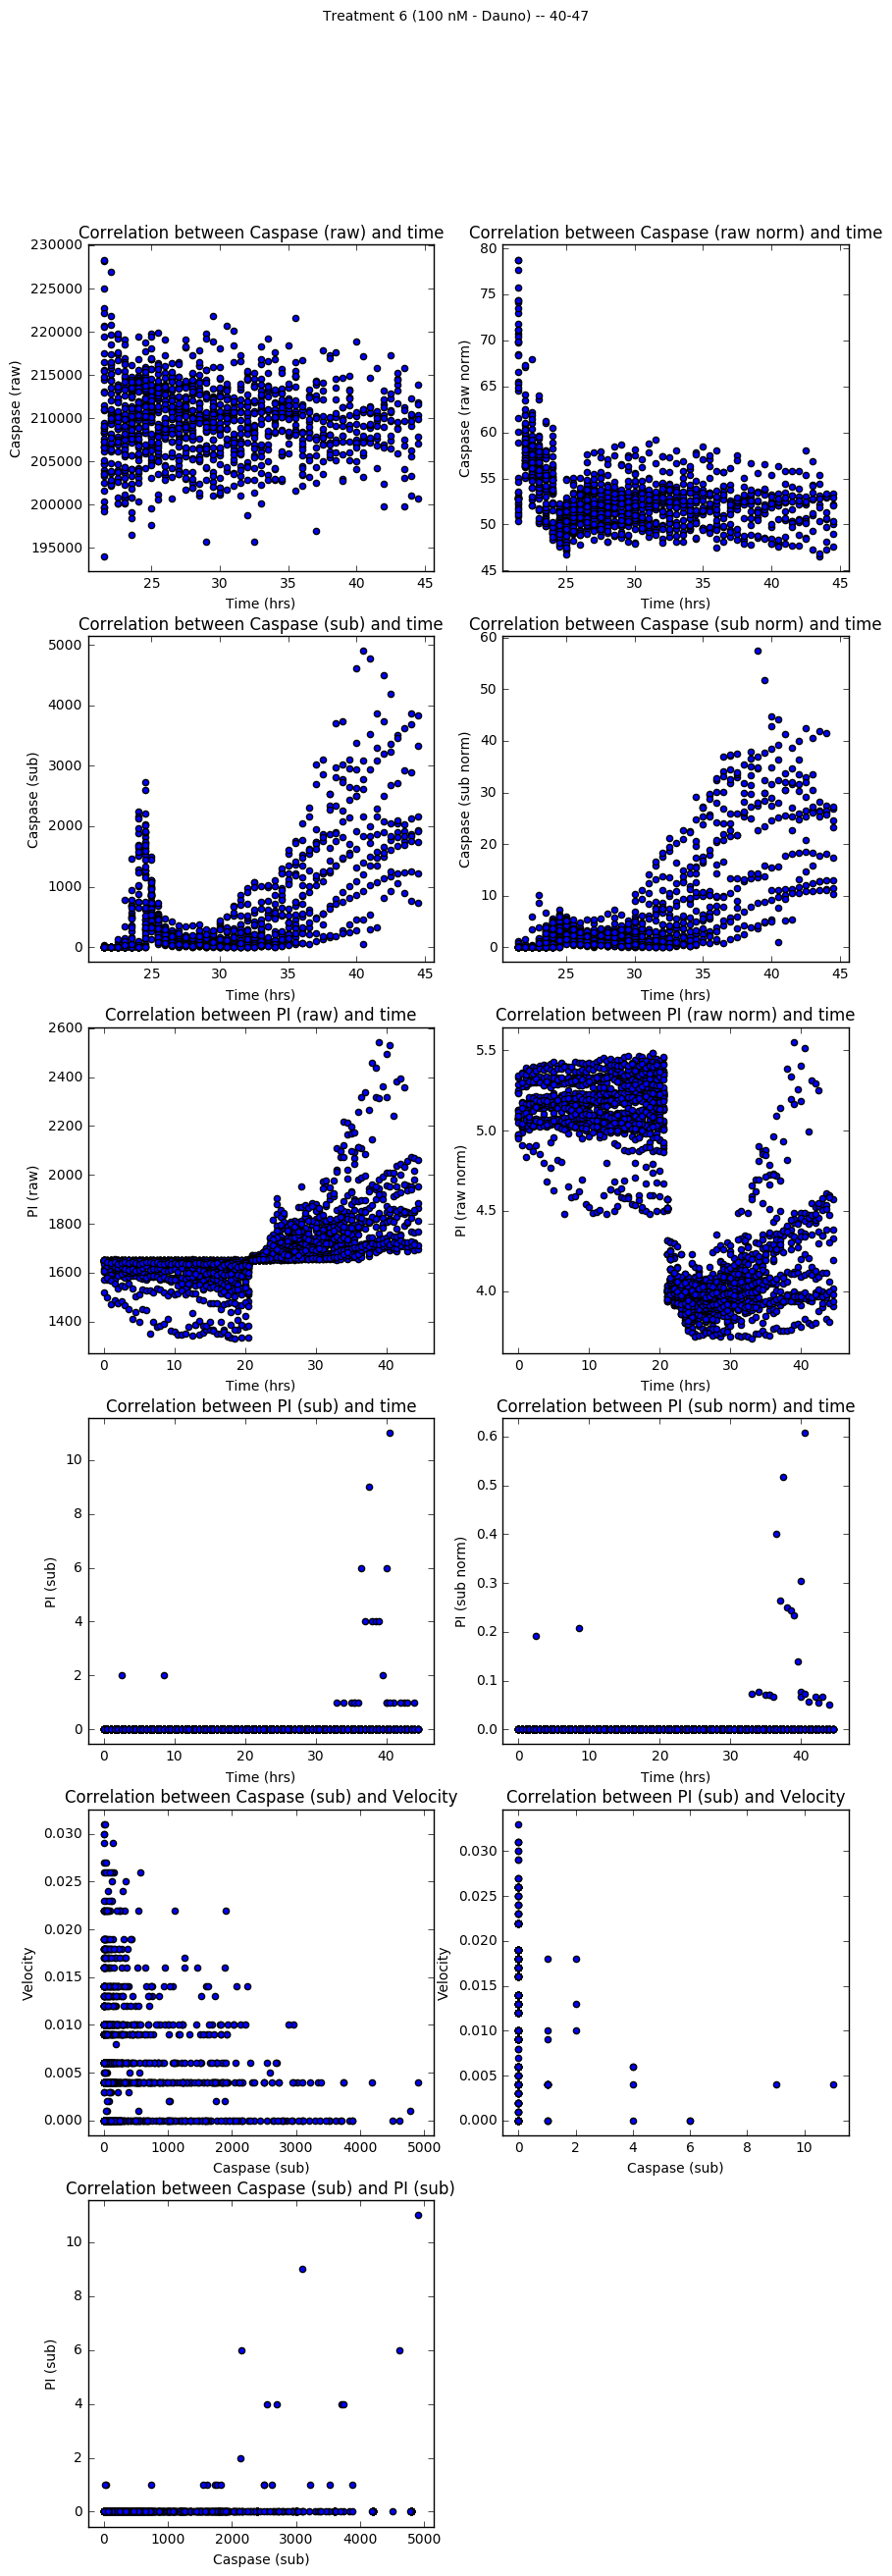

In [80]:
correlation_analysis_treatment([stringify_position(p) for p in trtmnt_6], "Treatment 6 (100 nM - Dauno) -- 40-47", dat_f)

C:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:3040: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))
C:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2782: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


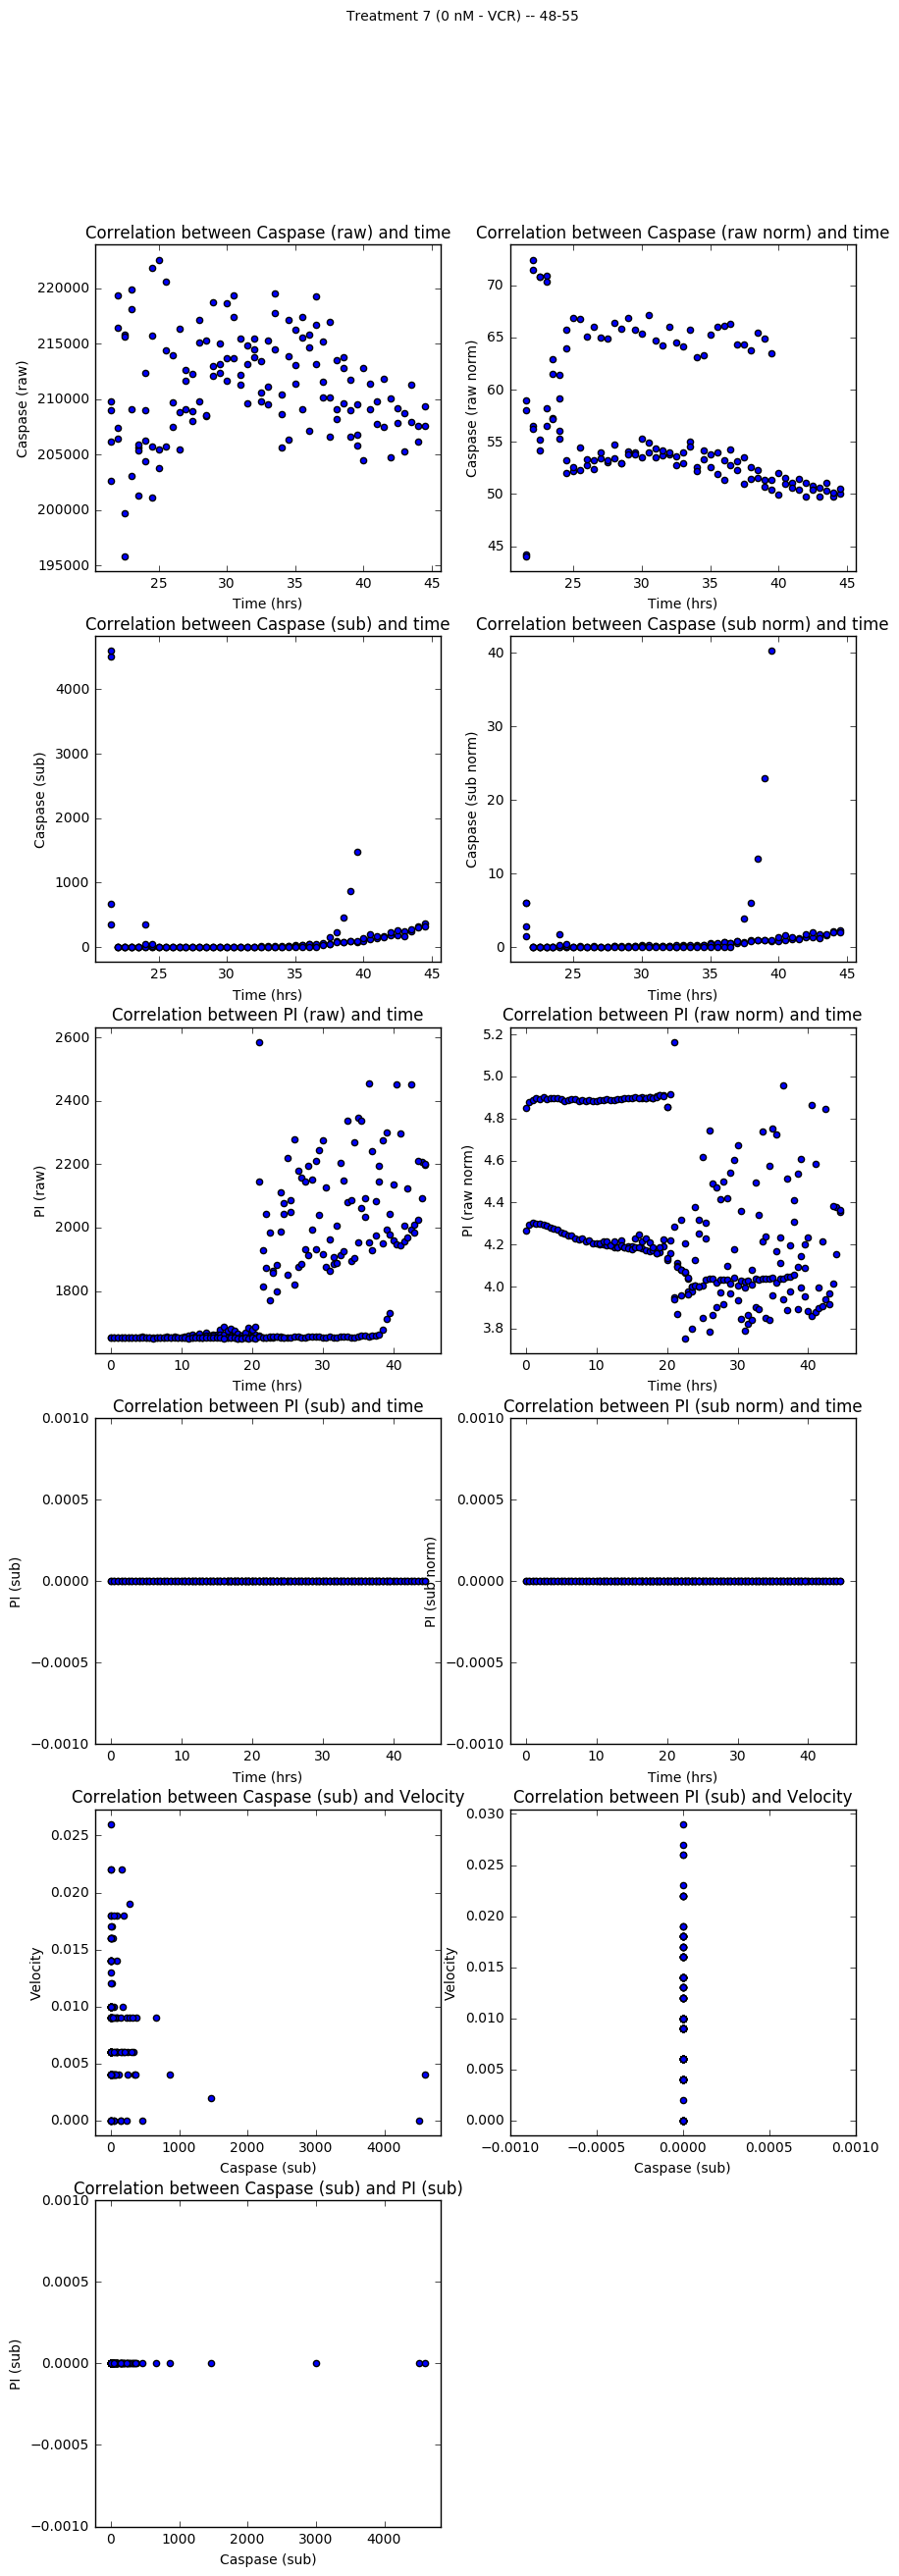

In [81]:
correlation_analysis_treatment([stringify_position(p) for p in trtmnt_7], "Treatment 7 (0 nM - VCR) -- 48-55", dat_f)

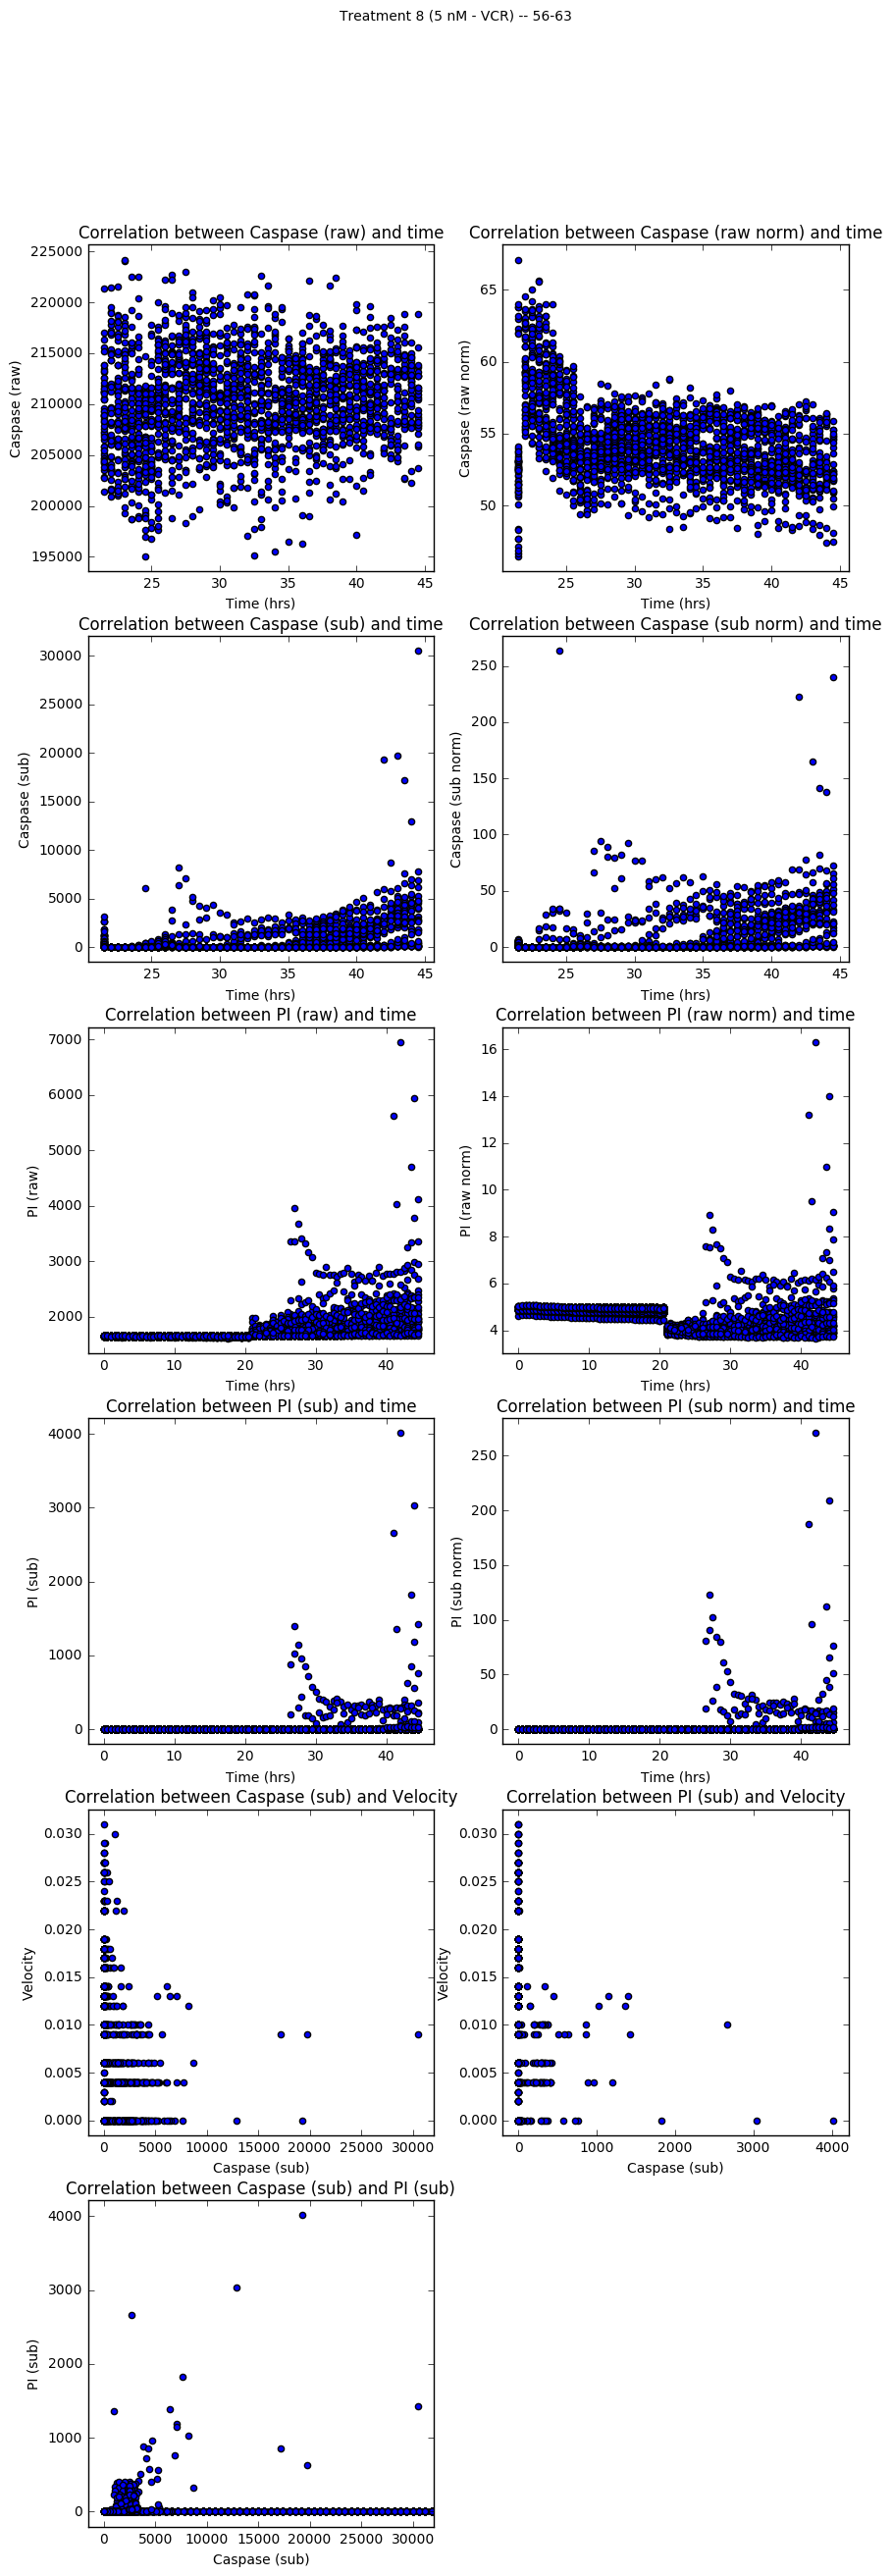

In [82]:
correlation_analysis_treatment([stringify_position(p) for p in trtmnt_8], "Treatment 8 (5 nM - VCR) -- 56-63", dat_f)

## III.4 Signal Thresholding Analysis

In [83]:
trtmnt_2

{9, 10, 12, 14, 15}

In [84]:
dat_f['09'].keys()

dict_keys(['TREES', 'GAP_PER_FRAME_SECONDS', 'PIXEL_TO_INCH'])

In [85]:
dat_f[pos]['TREES'][t].keys()

dict_keys(['VELOCITY', 'BRANCH', 'CASPASE_NORM', 'POSITION_X', 'POSITION_Y', 'CASPASE_SUB_NORM', 'CASPASE', 'PI_SUB', 'PI', 'PI_SUB_NORM', 'POSITION_T', 'TREE', 'DISPLACEMENT', 'PI_NORM', 'CASPASE_SUB'])

In [86]:
dat_f[pos]['TREES'][t].keys()

dict_keys(['VELOCITY', 'BRANCH', 'CASPASE_NORM', 'POSITION_X', 'POSITION_Y', 'CASPASE_SUB_NORM', 'CASPASE', 'PI_SUB', 'PI', 'PI_SUB_NORM', 'POSITION_T', 'TREE', 'DISPLACEMENT', 'PI_NORM', 'CASPASE_SUB'])

In [ ]:
# TODO

## III.5 SVM Regression

### III.5.1 SVM on all data

In [87]:
X = np.array([])
y = np.array([])
for ps in set(list(range(64))[1:]) - invalid:

    pos = stringify_position(ps)
    
    for t in dat_f[pos]['TREES']:

        t_tree = dat_f[pos]['TREES'][t]
        t_branch = dat_f[pos]['TREES'][t]['BRANCH']

        br1 = t_branch[t][0]
        br2 = t_branch[t][1]
        t_br1 = np.array(dat_f[pos]['TREES'][t]['POSITION_T'][br1])
        t_br2 = np.array(dat_f[pos]['TREES'][t]['POSITION_T'][br2])
        t_br1_sel = t_br1 > 21 * 3600
        t_br2_sel = t_br2 > 21 * 3600

        t_br1_pi = np.array(dat_f[pos]['TREES'][t]['PI_SUB'][br1])[t_br1_sel]
        t_br2_pi = np.array(dat_f[pos]['TREES'][t]['PI_SUB'][br2])[t_br2_sel]
        t_br1_caspase = np.array(dat_f[pos]['TREES'][t]['CASPASE_SUB'][br1])[t_br1_sel]
        t_br2_caspase = np.array(dat_f[pos]['TREES'][t]['CASPASE_SUB'][br2])[t_br2_sel]
        t_br1_velocity = np.array(dat_f[pos]['TREES'][t]['VELOCITY'][br1])[t_br1_sel]
        t_br2_velocity = np.array(dat_f[pos]['TREES'][t]['VELOCITY'][br2])[t_br2_sel]
        t_br1_displacement = np.array(dat_f[pos]['TREES'][t]['DISPLACEMENT'][br1])[t_br1_sel]
        t_br2_displacement = np.array(dat_f[pos]['TREES'][t]['DISPLACEMENT'][br2])[t_br2_sel]

        t_br1_ttd = np.abs(t_br1[t_br1_sel] - t_br1[t_br1_sel].max())
        t_br2_ttd = np.abs(t_br2[t_br2_sel] - t_br2[t_br2_sel].max())

        Xt1 = np.array([t_br1_pi, t_br1_caspase, t_br1_velocity, t_br1_displacement]).T
        Xt2 = np.array([t_br2_pi, t_br2_caspase, t_br2_velocity, t_br2_displacement]).T
        Xt = np.concatenate((Xt1, Xt2))
        yt = np.append(t_br1_ttd, t_br2_ttd)
        
        if X.shape[0] == 0:
            X = Xt
            y = yt
        else:
            X = np.concatenate((X, Xt))
            y = np.concatenate((y, yt))

In [88]:
## all data

X_valid = X[np.sum(np.isnan(X), axis=1) == 0,:]
y_valid = y[np.sum(np.isnan(X), axis=1) == 0]
svr = svm.SVR(kernel='rbf', C=1e3, gamma=0.1)
yp = svr.fit(X_valid, y_valid).predict(X_valid)
args = np.argsort(y_valid)
y_valid = y_valid[args]
yp = yp[args]

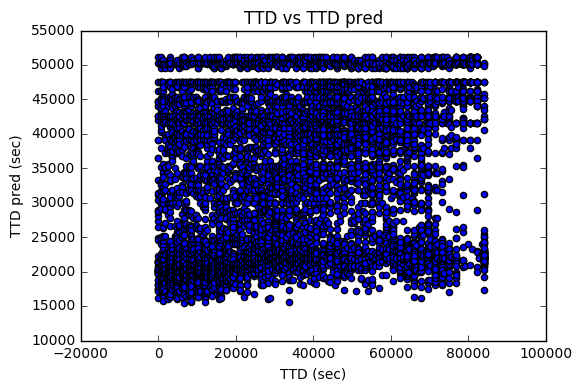

In [89]:
pt.scatter(y_valid, yp)
pt.title("TTD vs TTD pred")
pt.xlabel("TTD (sec)")
pt.ylabel("TTD pred (sec)")

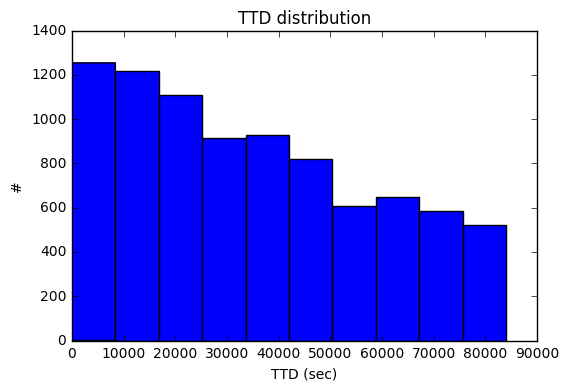

In [90]:
pt.hist(y_valid)
pt.title("TTD distribution")
pt.ylabel("#")
pt.xlabel("TTD (sec)")

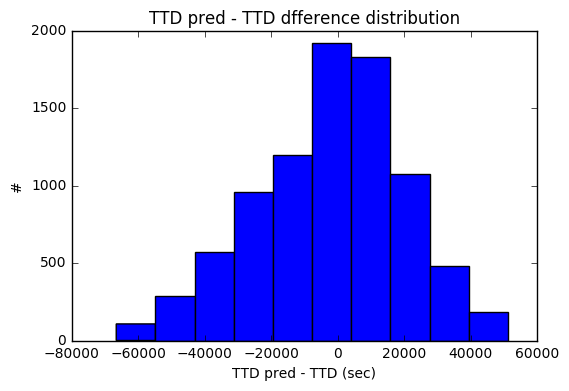

In [91]:
pt.hist(yp - y_valid)
pt.title("TTD pred - TTD dfference distribution")
pt.ylabel("#")
pt.xlabel("TTD pred - TTD (sec)")

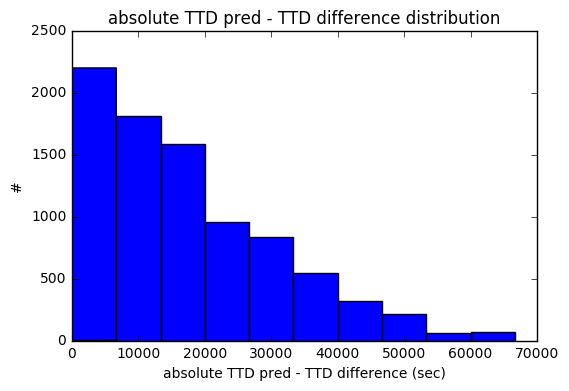

In [92]:
pt.hist(np.abs(yp - y_valid))
pt.title("absolute TTD pred - TTD difference distribution")
pt.ylabel("#")
pt.xlabel("absolute TTD pred - TTD difference (sec)")

### III.5.2 SVM on the last 7200 secs data

In [93]:
## last 7200 secs

X_valid = X[np.sum(np.isnan(X), axis=1) == 0,:]
y_valid = y[np.sum(np.isnan(X), axis=1) == 0]
X_valid = X_valid[y_valid <= 7200,:]
y_valid = y_valid[y_valid <= 7200]
svr = svm.SVR(kernel='rbf', C=1e3, gamma=0.1)
yp = svr.fit(X_valid, y_valid).predict(X_valid)
args = np.argsort(y_valid)
y_valid = y_valid[args]
yp = yp[args]

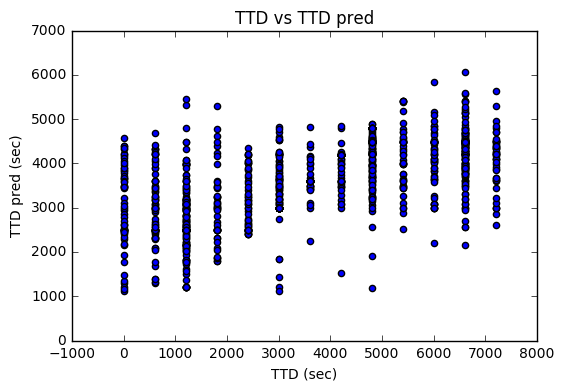

In [94]:
## TODO: change to Time-to-End-of-Track (TTE)
## TODO: different color before and after treatment

pt.scatter(y_valid, yp)
pt.title("TTD vs TTD pred")
pt.xlabel("TTD (sec)")
pt.ylabel("TTD pred (sec)")

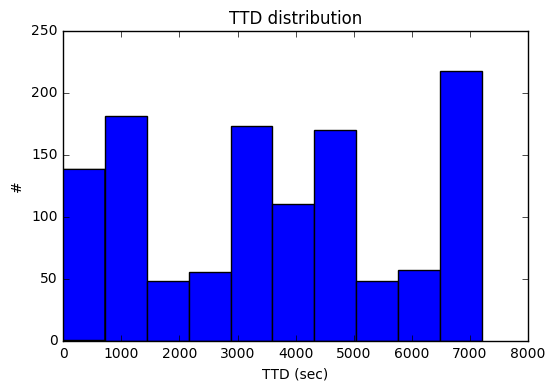

In [95]:
pt.hist(y_valid)
pt.title("TTD distribution")
pt.ylabel("#")
pt.xlabel("TTD (sec)")

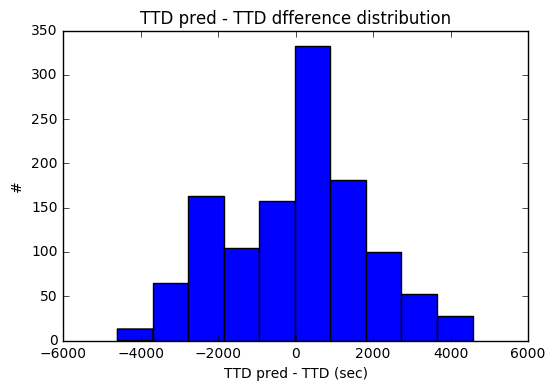

In [96]:
pt.hist(yp - y_valid)
pt.title("TTD pred - TTD dfference distribution")
pt.ylabel("#")
pt.xlabel("TTD pred - TTD (sec)")

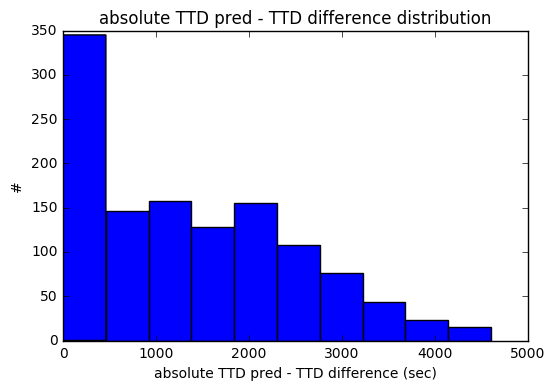

In [97]:
pt.hist(np.abs(yp - y_valid))
pt.title("absolute TTD pred - TTD difference distribution")
pt.ylabel("#")
pt.xlabel("absolute TTD pred - TTD difference (sec)")

### III.5.3 SVM on the last 14400 secs data

In [98]:
## last 14400 secs

X_valid = X[np.sum(np.isnan(X), axis=1) == 0,:]
y_valid = y[np.sum(np.isnan(X), axis=1) == 0]
X_valid = X_valid[y_valid <= 14400,:]
y_valid = y_valid[y_valid <= 14400]
svr = svm.SVR(kernel='rbf', C=1e3, gamma=0.1)
yp = svr.fit(X_valid, y_valid).predict(X_valid)
args = np.argsort(y_valid)
y_valid = y_valid[args]
yp = yp[args]

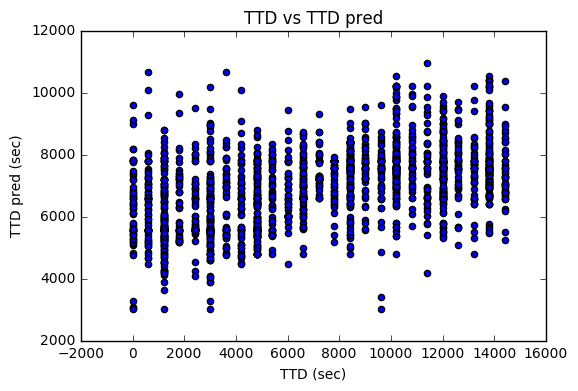

In [99]:
pt.scatter(y_valid, yp)
pt.title("TTD vs TTD pred")
pt.xlabel("TTD (sec)")
pt.ylabel("TTD pred (sec)")

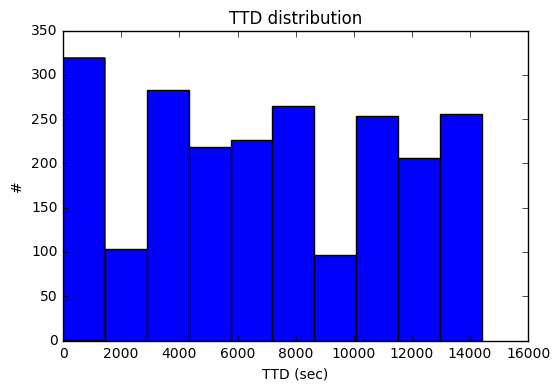

In [100]:
pt.hist(y_valid)
pt.title("TTD distribution")
pt.ylabel("#")
pt.xlabel("TTD (sec)")

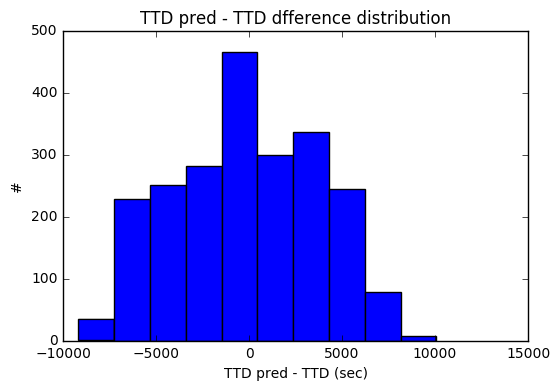

In [101]:
pt.hist(yp - y_valid)
pt.title("TTD pred - TTD dfference distribution")
pt.ylabel("#")
pt.xlabel("TTD pred - TTD (sec)")

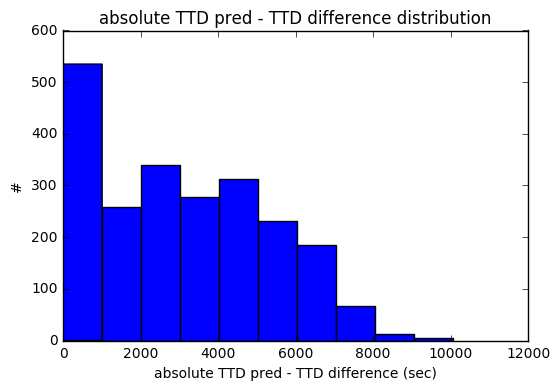

In [102]:
pt.hist(np.abs(yp - y_valid))
pt.title("absolute TTD pred - TTD difference distribution")
pt.ylabel("#")
pt.xlabel("absolute TTD pred - TTD difference (sec)")

### III.5.4 SVM on various data slices

In [103]:
# X = np.array([])
# y = np.array([])

X_map = {v:np.array([]) for v in range(5)}
y_map = {v:np.array([]) for v in range(5)}

for ps in set(list(range(64))[1:]) - invalid:

    pos = stringify_position(ps)
    
    for t in dat_f[pos]['TREES']:

        t_tree = dat_f[pos]['TREES'][t]
        t_branch = dat_f[pos]['TREES'][t]['BRANCH']

        br1 = t_branch[t][0]
        br2 = t_branch[t][1]
        t_br1 = np.array(dat_f[pos]['TREES'][t]['POSITION_T'][br1])
        t_br2 = np.array(dat_f[pos]['TREES'][t]['POSITION_T'][br2])
        
        ## acquire values starting with i-th pentile
        for i in range(5):
            t_br1_sel = t_br1 > np.percentile(t_br1[t_br1 >= (21 * 3600)] , i * 20)
            t_br2_sel = t_br2 > np.percentile(t_br2[t_br2 >= (21 * 3600)] , i * 20)
            

            t_br1_pi = np.array(dat_f[pos]['TREES'][t]['PI_SUB'][br1])[t_br1_sel]
            t_br2_pi = np.array(dat_f[pos]['TREES'][t]['PI_SUB'][br2])[t_br2_sel]
            t_br1_caspase = np.array(dat_f[pos]['TREES'][t]['CASPASE_SUB'][br1])[t_br1_sel]
            t_br2_caspase = np.array(dat_f[pos]['TREES'][t]['CASPASE_SUB'][br2])[t_br2_sel]
            t_br1_velocity = np.array(dat_f[pos]['TREES'][t]['VELOCITY'][br1])[t_br1_sel]
            t_br2_velocity = np.array(dat_f[pos]['TREES'][t]['VELOCITY'][br2])[t_br2_sel]
            t_br1_displacement = np.array(dat_f[pos]['TREES'][t]['DISPLACEMENT'][br1])[t_br1_sel]
            t_br2_displacement = np.array(dat_f[pos]['TREES'][t]['DISPLACEMENT'][br2])[t_br2_sel]

            t_br1_ttd = np.abs(t_br1[t_br1_sel] - t_br1[t_br1_sel].max())
            t_br2_ttd = np.abs(t_br2[t_br2_sel] - t_br2[t_br2_sel].max())

            Xt1 = np.array([t_br1_pi, t_br1_caspase, t_br1_velocity, t_br1_displacement]).T
            Xt2 = np.array([t_br2_pi, t_br2_caspase, t_br2_velocity, t_br2_displacement]).T
            Xt = np.concatenate((Xt1, Xt2))
            yt = np.append(t_br1_ttd, t_br2_ttd)
        
            if X_map[i].shape[0] == 0:
                X_map[i] = Xt
                y_map[i] = yt
            else:
                X_map[i] = np.concatenate((X_map[i], Xt))
                y_map[i] = np.concatenate((y_map[i], yt))

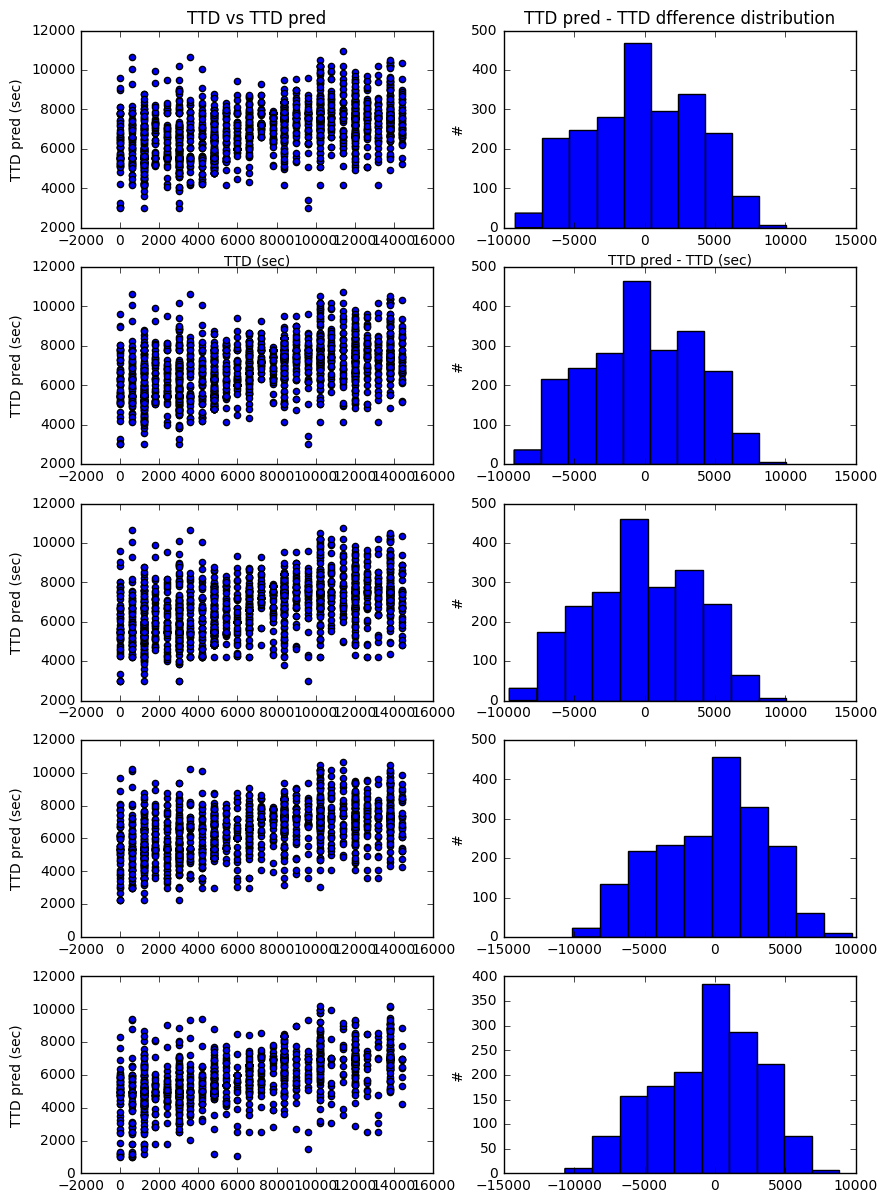

In [104]:
for i in X_map:

    X = X_map[i]
    y = y_map[i]
    
    X_valid = X[np.sum(np.isnan(X), axis=1) == 0,:]
    y_valid = y[np.sum(np.isnan(X), axis=1) == 0]
    X_valid = X_valid[y_valid <= 14400,:]
    y_valid = y_valid[y_valid <= 14400]
    svr = svm.SVR(kernel='rbf', C=1e3, gamma=0.1)
    yp = svr.fit(X_valid, y_valid).predict(X_valid)
    args = np.argsort(y_valid)
    y_valid = y_valid[args]
    yp = yp[args]
    
    pt.subplot(10, 2, i * 2 + 1)
    pt.scatter(y_valid, yp)
#     maxval = max(np.max(y_valid), np.max(yp))
#     pt.plot(range(maxval), range(maxval))
    if i == 0:
        pt.title("TTD vs TTD pred")
        pt.xlabel("TTD (sec)")
    pt.ylabel("TTD pred (sec)")
 
    pt.subplot(10, 2, i * 2 + 2)
    pt.hist(yp - y_valid)
    pt.ylabel("#")
    if i == 0:
        pt.title("TTD pred - TTD dfference distribution")
        pt.xlabel("TTD pred - TTD (sec)")
    
pt.gcf().set_size_inches(10, 30)

## III.6 TTD Regression using visual features

## X. Debugging

In [175]:
pics_casp_sub[0].dtype

dtype('>u2')

In [132]:
pos = stringify_position(10)

pics = get_video('../test/eli-new-unsync-bf-10/pi/merged/merged.tif')
pics = [pc.astype(np.int64) for pc in pics]

In [96]:
print("done")

done


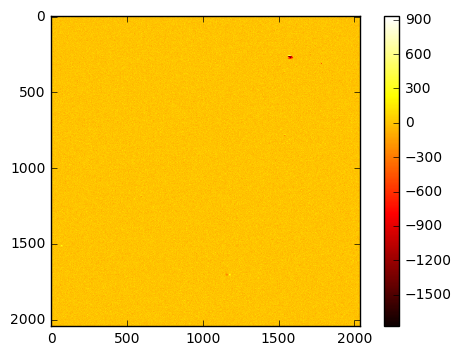

In [133]:
pt.imshow(pics[0] - pics[2], cmap='hot')
pt.colorbar()

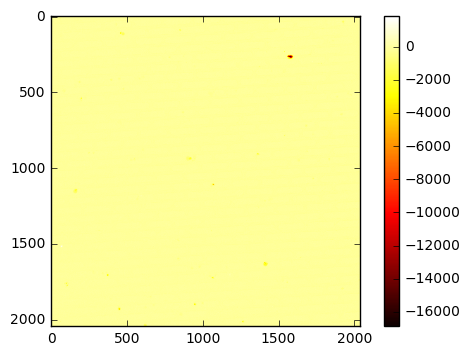

In [134]:
pt.imshow(pics[0] - pics[89], cmap='hot')
pt.colorbar()

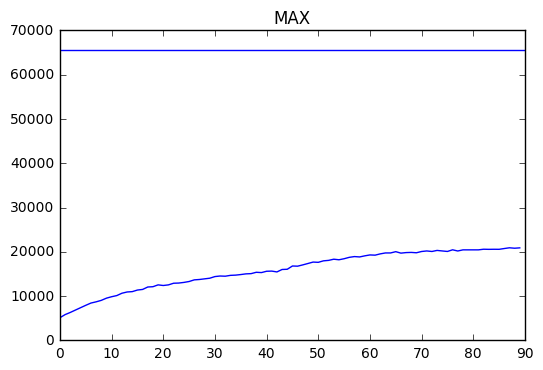

In [136]:
mx = [np.max(p.ravel()) for p in pics]
pt.plot(range(len(mx)), mx)
pt.title("MAX")
pt.axhline(65535)

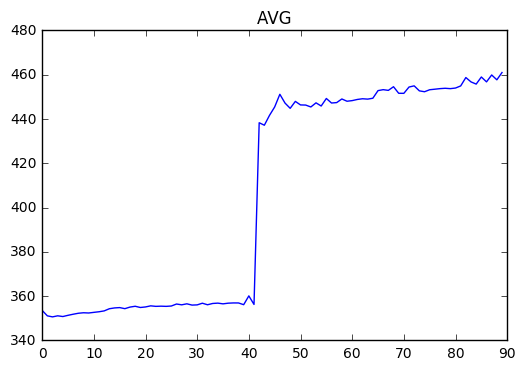

In [138]:
avg = [(np.sum(p.ravel()) / (p.shape[0] * p.shape[1])) for p in pics]
pt.plot(range(len(avg)), avg)
pt.title("AVG")

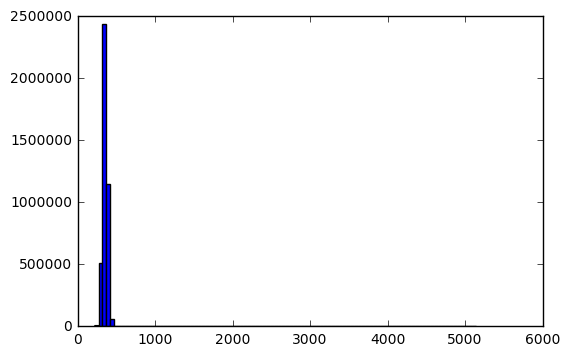

In [99]:
pt.hist(pics[0].ravel(),bins=100)
pt.show()

In [ ]:
pt.imshow(pics[11], cmap='hot', interpolation='nearest')
pt.gcf().set_size_inches(10, 10)


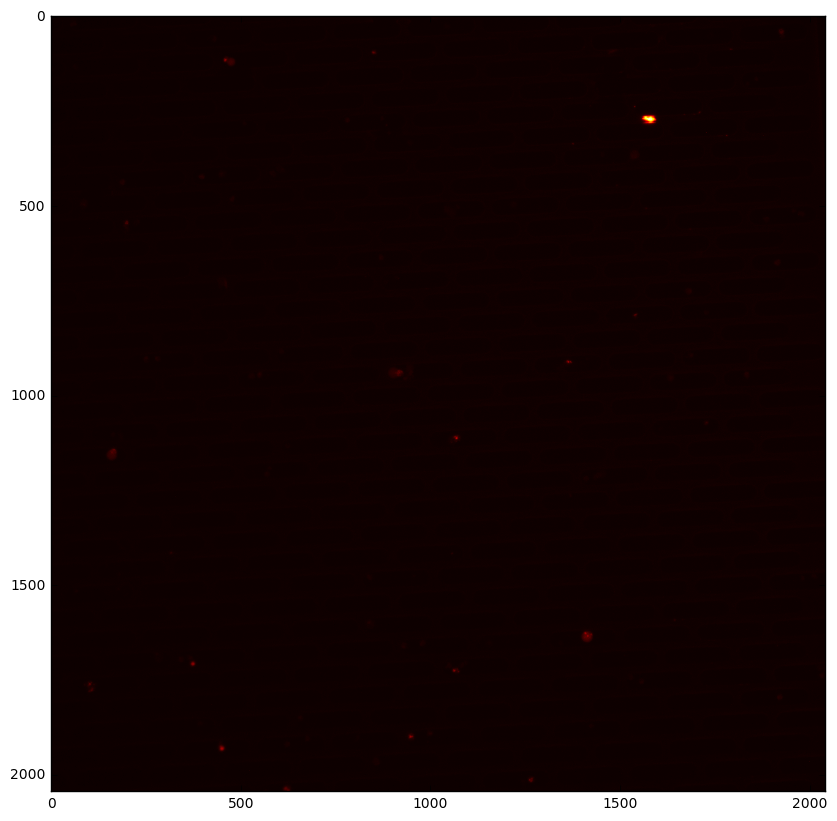

In [139]:
pt.imshow(pics[89], cmap='hot')
pt.gcf().set_size_inches(10, 10)


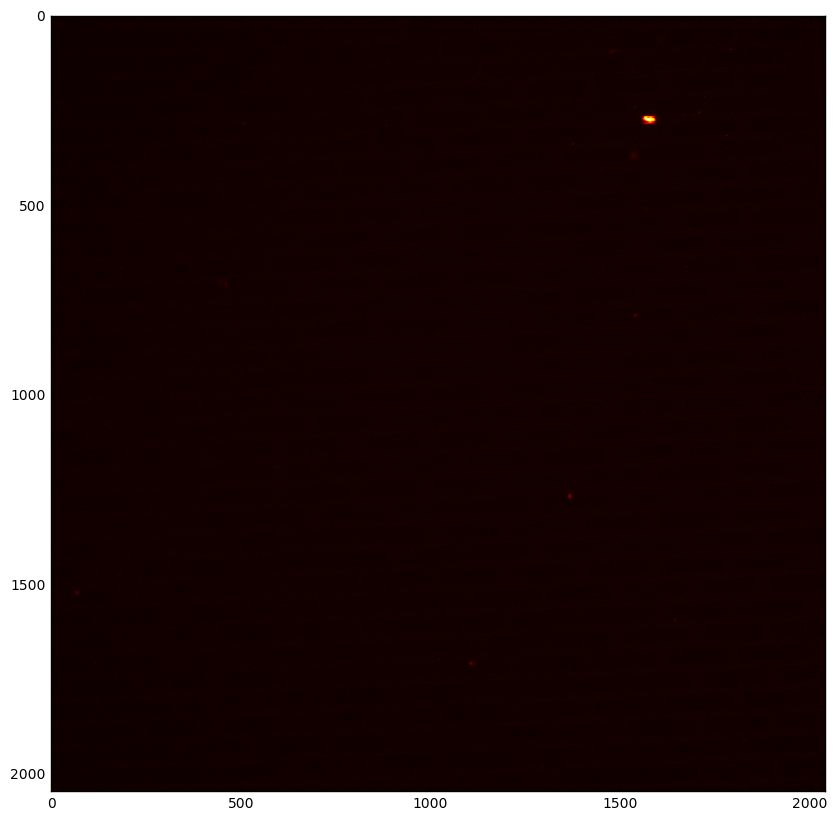

In [140]:
pt.imshow(pics[11], cmap='hot', interpolation='nearest')
pt.gcf().set_size_inches(10, 10)


# TEST